# Training code for Fastai U-net architecture on wavefield dataset
Los Alamos Dynamics Summer School (LADSS)  
Team: DeepWaves  
Date: August 17, 2020  
Author: Joshua Eckels (eckelsjd@rose-hulman.edu)  
See training_instructions.txt in documentation folder for details.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.vision.interpret import SegmentationInterpretation

# to clear GPU cache
from torch import cuda as cd

# for IoU and Dice metrics
import torch
from torch.nn import functional as F

# for create_valid function
import os
import random
import math

# for transforms
from skimage.util import random_noise
import PIL

# To ignore rcParams['figure.max_open_warning']
import matplotlib

In [3]:
# Automatically generate valid.txt for splitting 20/80 validation and training sets
def create_valid(path:PathOrStr,pct:float=0.2)->None:
    # get contents of image directory
    path = Path(path)
    imgs = [f for f in os.listdir(path/'images') if not f.startswith('.')]
    random.shuffle(imgs)
    
    # calculate total number of image files needed in 'valid.txt'
    total_valid = int(math.ceil(pct * len(imgs)))
    
    # open 'valid.txt' for writing
    try:
        fd = open(path/'src'/'valid.txt',"x")
    except FileExistsError:
        print("File 'valid.txt' already exists. Exiting...")
        return
    
    # Loop through filenames and add count
    i = 0
    for img in imgs:
        if (i >= total_valid):
            break;
        
        # Avoid augmentation images
        if 'aug' in img:
            continue;
            
        fd.write(f'{img}\n')
        i = i+1
        
    # Close file
    fd.close()
    return

In [4]:
# Return Jaccard index, or Intersection over Union (IoU) value
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [5]:
# Return Dice coefficient, or F1 score = 2*intersection / cardinality
def dice(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the dice coefficient
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        dice_coeff
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    dice_coeff = (2 * intersection / (cardinality + eps)).mean()   # find mean of class dice values
    return dice_coeff

In [6]:
# Custom augmentation function to add gaussian noise
# Called on the fly between epochs in training
# x = fastai.Image.px pixel values ?
# IGNORE for now; not used
def _gaussian(x):
    val = np.random.random_sample()
    if val > 0.5:
        pil_img = PIL.Image.fromarray(image2np(x*255).astype('uint8'))
        np_img = np.array(pil_img)
        noise_img = random_noise(np_img,mode='gaussian',var=0.01)
        noise_img = (255*noise_img).astype(np.uint8)
        pil_img = PIL.Image.fromarray(noise_img)
        
        x = pil2tensor(pil_img,np.float32)
        x.div_(255)
    
    return x

In [7]:
# clear GPU cache
cd.empty_cache()

# get training data
# path = untar_data(URLs.CAMVID)
path = Path("..")
codes = np.loadtxt(path/'src'/'codes.txt',dtype=str)
# write codes.txt by hand for desired classes

name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['10'] # plate thickness = 10 mm
# use 'Void' class for background

path_lbl = path/'labels'
path_img = path/'images'

fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

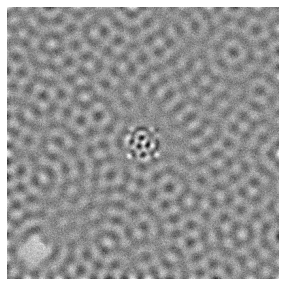

In [8]:
# show example image
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
# Determine type of image
filename = str(img_f)
if '_magnitude' in filename:
    token = '_magnitude'
elif '_real' in filename:
    token = '_real'
elif '_imaginary' in filename:
    token = '_imaginary'
else:
    print("Error: image needs to contain one of the above")

In [10]:
# function to get label path from image filename
get_y_fn = lambda x: path_lbl/f'{x.stem.split(token)[0]}_mask{x.suffix}'

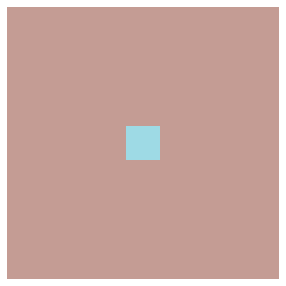

In [11]:
# show image mask
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
# Training parameters
src_size = np.array(mask.shape[1:])
# torch.Size([1,400,400]) [C,H,W]
bs = 16 # Batch size

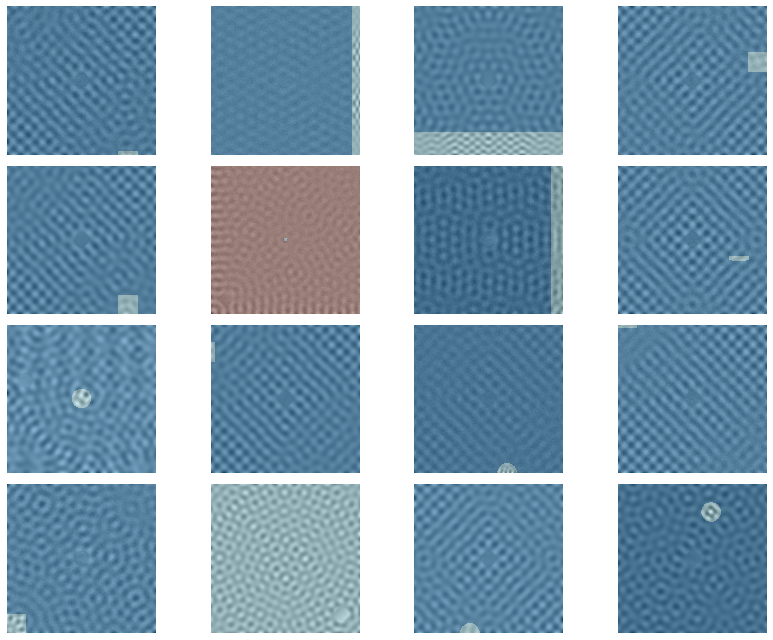

In [13]:
# Setup Data
src = SegmentationItemList.from_folder(path_img)     # GET images
# fastai.vision.data.SegmentationItemList :: ItemList

#create_valid(path)
# src = src.split_by_fname_file('valid.txt',path/'src') # SPLIT valid/train
src = src.split_by_rand_pct()
# fastai.data_block.ItemLists

src = src.label_from_func(get_y_fn, classes=codes)    # LABEL classes
# fastai.data_block.LabelLists

# Transforms to perform on the fly: horizontal/vertical flips

tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=None,max_zoom=1,
                     max_lighting=None,max_warp=None,p_lighting=0)

# Gaussian noise on-the-fly 
# Don't apply gaussian transform to labels (use_on_y=False)
# gaussian = TfmPixel(_gaussian)
# new_tfms = (tfms[0] + [gaussian(use_on_y=False)],tfms[1])

data = (src.transform(tfms,size=src_size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
# fastai.basic_data.DataBunch

data.show_batch(rows=5, figsize=(12,9))

In [14]:
# Create U-net Learner object
learn = unet_learner(data,models.resnet34,metrics=[IoU,dice])
learn.path = Path("..")

# TODO: Custom U-net class to implement Refine-Net
# TODO: Optimize weight decay and percent start params (wd=0.01 and pct_start=0.3)

epoch,train_loss,valid_loss,IoU,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


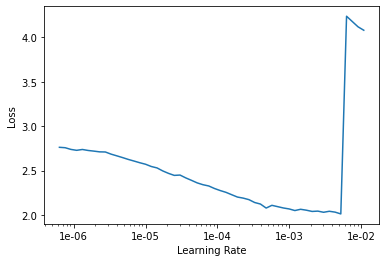

In [17]:
# Train model
# STAGE 1 : OPTIMIZE learning rate
learn.lr_find()
learn.recorder.plot()

In [18]:
lr = 1e-04
learn.fit_one_cycle(30,slice(lr))
learn.save('rd4-aug30-stage1')

epoch,train_loss,valid_loss,IoU,dice,time
0,1.693055,1.399989,0.067207,0.095828,01:52
1,1.319783,1.000117,0.103610,0.139760,01:50
2,1.049808,0.822975,0.130130,0.176581,01:50
3,0.924942,0.699599,0.150742,0.213724,01:50
4,0.834429,0.739735,0.157751,0.216586,01:50
5,0.724949,0.535002,0.208232,0.282895,01:50
6,0.682489,0.521510,0.236983,0.311302,01:50
7,0.695489,0.508524,0.230895,0.312064,01:50
8,0.648968,0.503769,0.241827,0.325677,01:50
9,0.619975,0.577946,0.210402,0.277624,01:50


epoch,train_loss,valid_loss,IoU,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


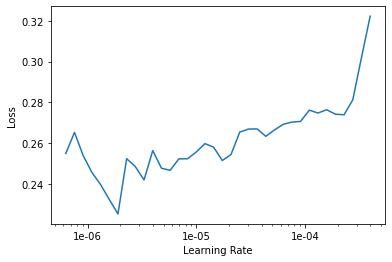

In [19]:
learn.load('rd4-aug30-stage1')

# STAGE 2 : UNFREEZE
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
lower_lr_bound = 7e-05
learn.fit_one_cycle(40,slice(lower_lr_bound,lr/5))
learn.save('rd4-aug40-stage2')

epoch,train_loss,valid_loss,IoU,dice,time
0,0.241008,0.199890,0.456256,0.534167,01:54
1,0.213625,0.188639,0.461972,0.539576,01:54
2,0.214097,0.180339,0.469574,0.545848,01:54
3,0.207097,0.170905,0.470088,0.547333,01:54
4,0.193347,0.167243,0.480139,0.555791,01:54
5,0.196629,0.149309,0.480603,0.556930,01:54
6,0.168852,0.152452,0.491291,0.567773,01:54
7,0.160197,0.110093,0.523092,0.593213,01:54
8,0.136470,0.094583,0.538742,0.606226,01:54
9,0.148398,0.106605,0.527361,0.598587,01:54


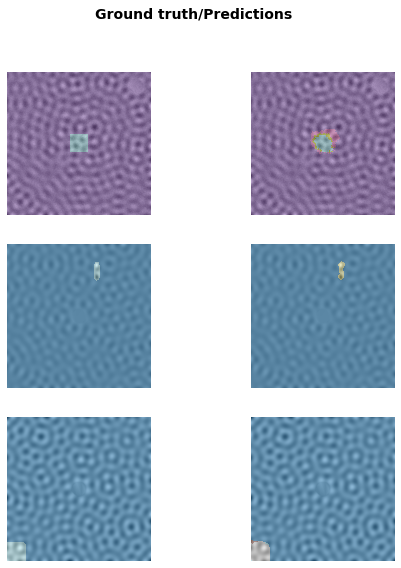

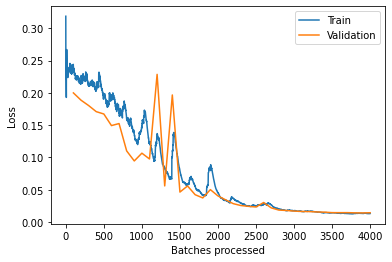

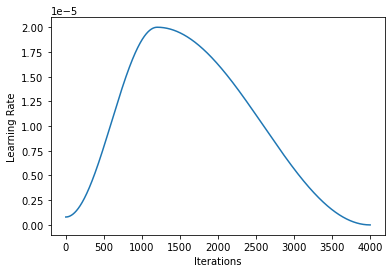

In [21]:
# Results
learn.show_results(rows=3,figsize=(8,9))
learn.recorder.plot_losses()
learn.recorder.plot_lr()    

In [16]:
# Export model for deployment
# DOES NOT work with segmentation interpret object; that requires learner to have data already loaded
# learn.export() # to 'learn.path/'export.pkl'

In [1]:
# Batch prediction
# learn = load_learner(Path(".."),test=SegmentationItemList.from_folder(Path("../test")),tfm_y=False)
# preds,y = learn.get_preds(ds_type=DatasetType.Test)
# predicted_masks = np.argmax(preds,axis=1) # get highest class probabilities (dim 1)
# predicted_masks = torch.unsqueeze(predicted_masks,1) # shape = [len(test),1,400,400]
# mask = ImageSegment(predicted_masks[4]) # convert torch.Tensor to fastai.image.ImageSegment
# img = learn.data.test_dl.dataset[4][0]
# img.show(y=mask)

In [15]:
learn.load('rd4-aug40-stage2')

Learner(data=ImageDataBunch;

Train: LabelList (1610 items)
x: SegmentationItemList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: SegmentationLabelList
ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400)
Path: ../images;

Valid: LabelList (402 items)
x: SegmentationItemList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: SegmentationLabelList
ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400),ImageSegment (1, 400, 400)
Path: ../images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(k

In [16]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 200, 200]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 200, 200]       128        True      
______________________________________________________________________
ReLU                 [64, 200, 200]       0          False     
______________________________________________________________________
MaxPool2d            [64, 100, 100]       0          False     
______________________________________________________________________
Conv2d               [64, 100, 100]       36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 100, 100]       128        True      
______________________________________________________________________
ReLU                 [64, 100, 100]       0          False     
__________________________________________________

In [16]:
# TESTING CELLS
files = [f for f in os.listdir("../test") if not f.startswith(".")]
interp = SegmentationInterpretation.from_learner(learn)
classes = [x for x in learn.data.classes]

In [17]:
# We're about to plot len(files) figures without closing any
# So let's ignore the matplotlib default memory warning here (default = 20)
matplotlib.rcParams['figure.max_open_warning'] = len(files) + 1

In [18]:
# Get this color list from colorgorical tool: http://vrl.cs.brown.edu/color
#color_list = ["#8de4d3", "#82252a", "#55f17b", "#db11ac", "#b0e472", "#6849b9", "#6f7d43", "#dfccfa", "#145a6a", "#f95a4e"]
color_list = [(127,0,0),(255,0,0),(255,127,0),(255,255,0),(191,255,62),(62,255,191),(0,255,255),(0,127,255),(0,0,255),(0,0,127)]

# Convert [0:255] colors to [0:1]
rgba = []
for i in range(len(color_list)):
    color = color_list[i]
    color_rgba = tuple(val/255.0 for val in color)
    rgba.append(color_rgba)
    
rgba.reverse()
    
# Use this workaround to ensure a constant colormap
# Add 'norm' kwarg to fastai.vision.interpret.SegmentationInterpretation._interp_show in both calls to "imshow"
# SEE: https://riptutorial.com/matplotlib/example/20692/custom-discrete-colormap
cmap = matplotlib.colors.ListedColormap(rgba)
boundaries = [0,1,2,3,4,5,6,7,8,9,10]
norm = matplotlib.colors.BoundaryNorm(boundaries,cmap.N,clip=True)

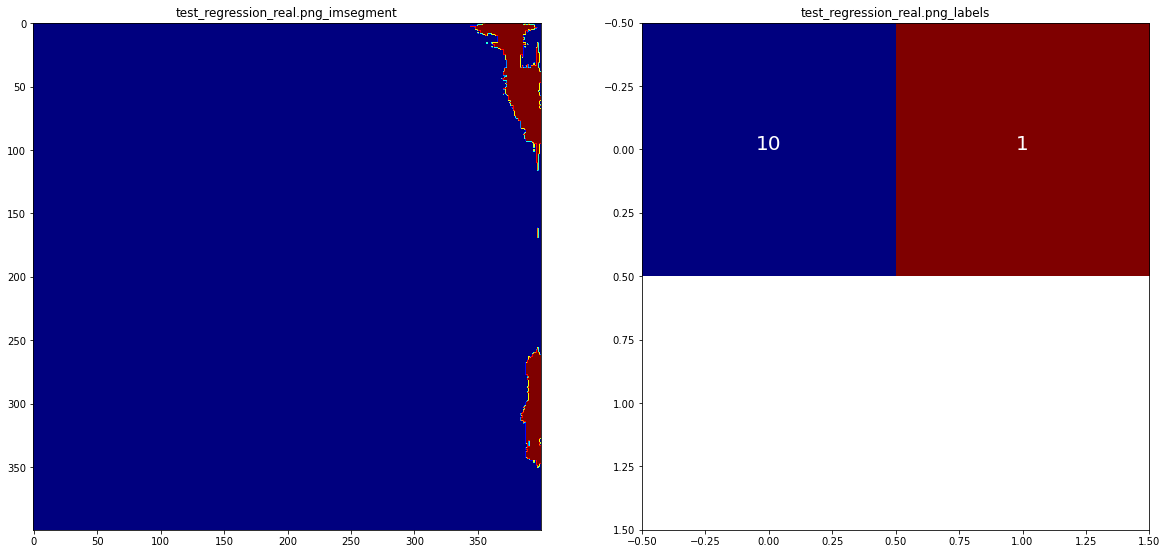

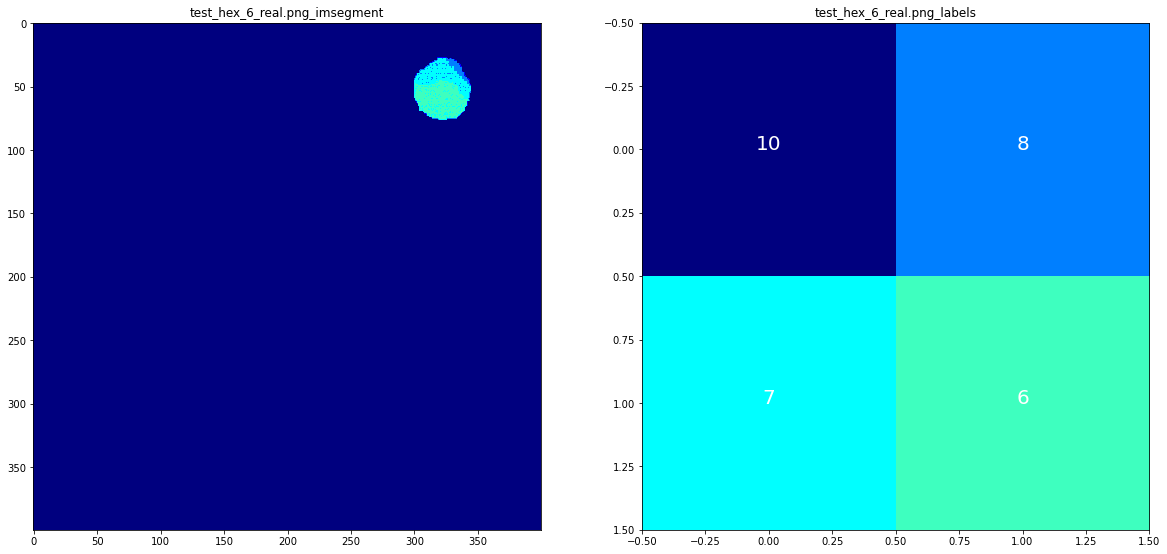

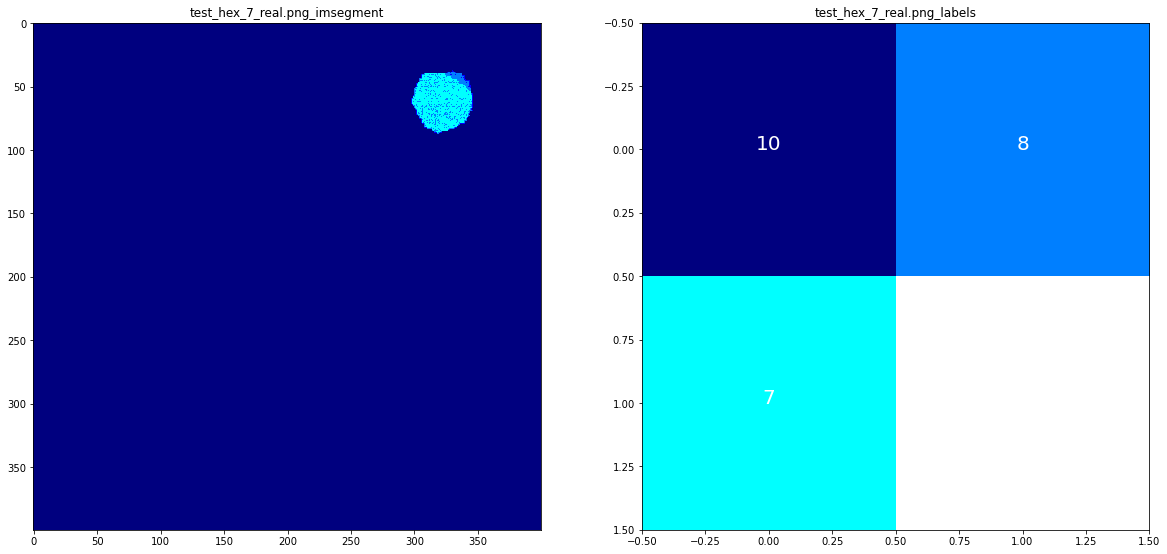

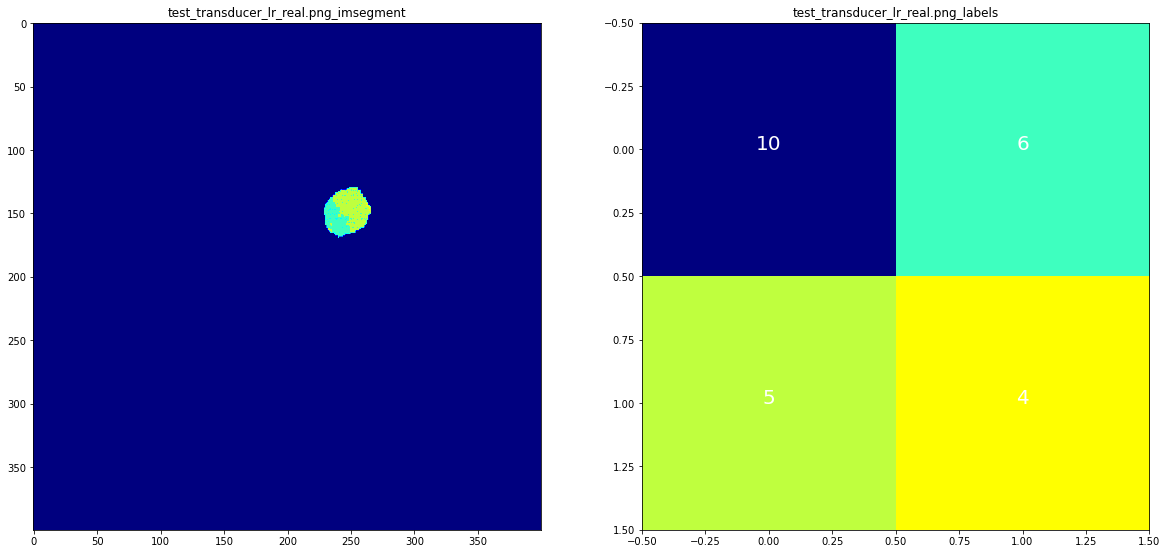

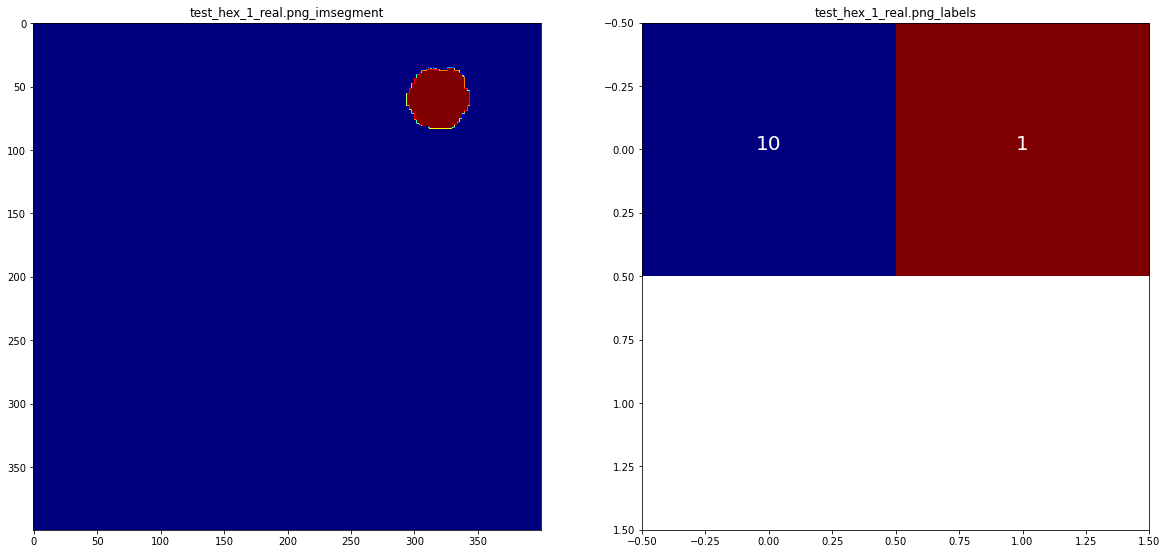

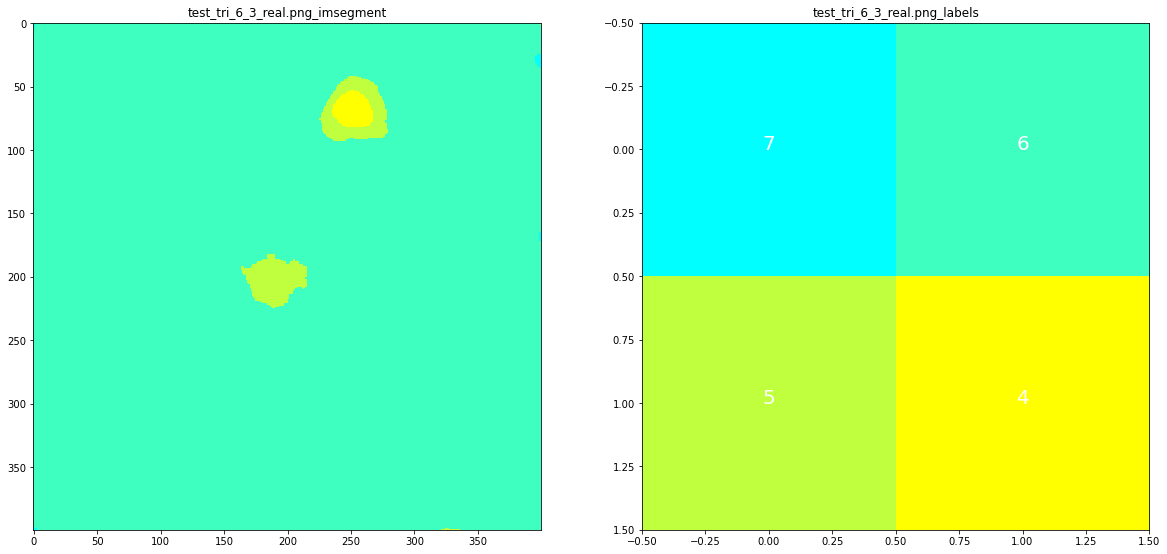

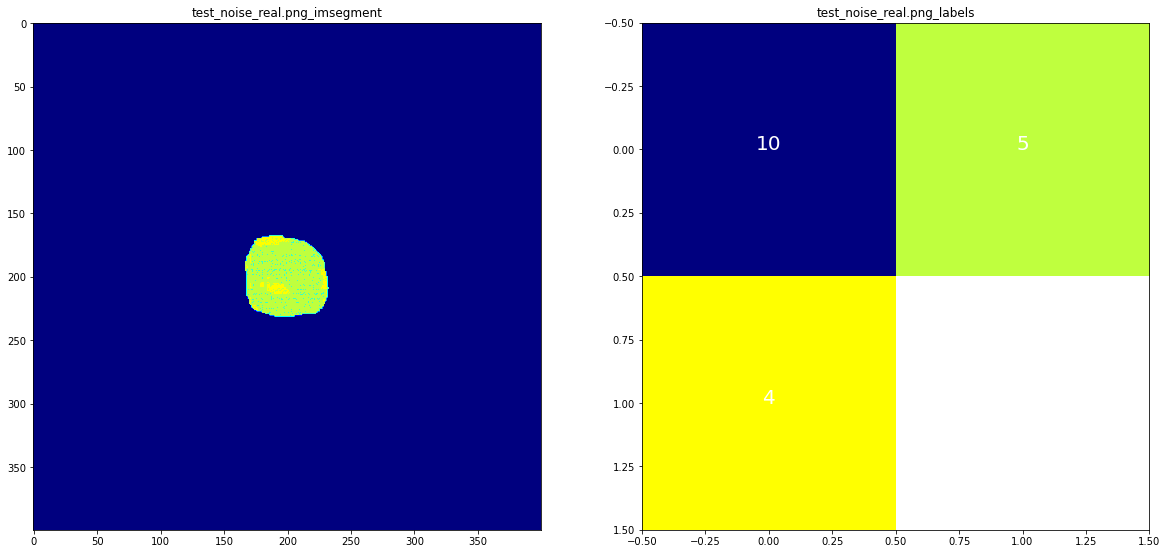

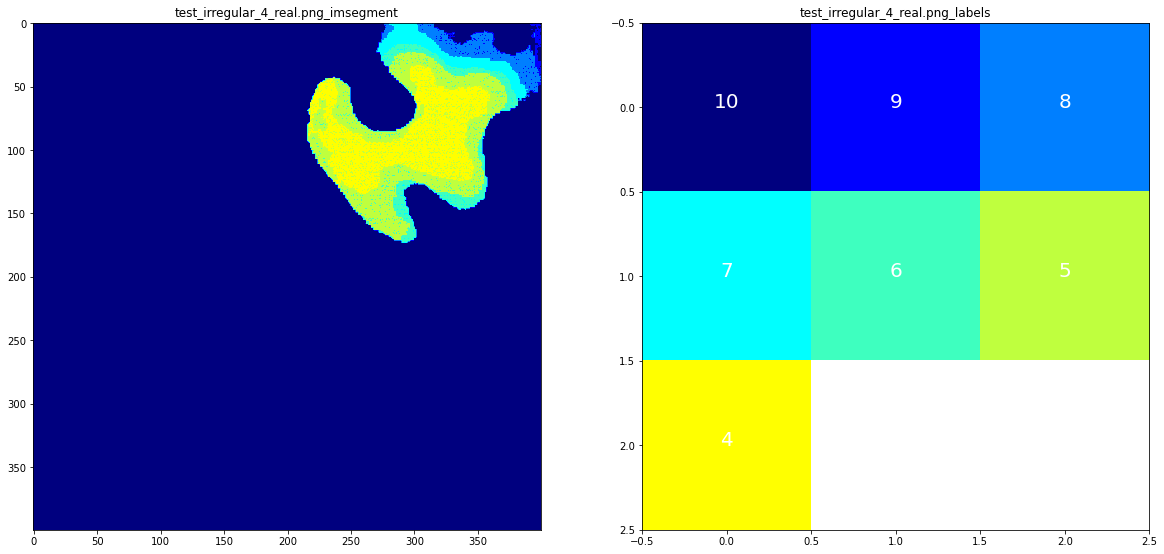

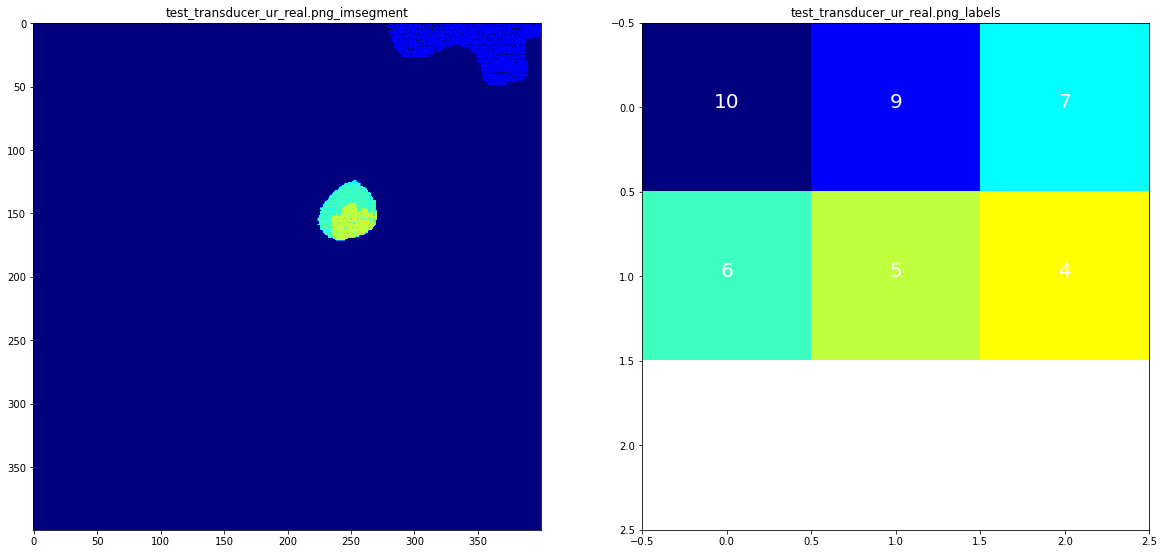

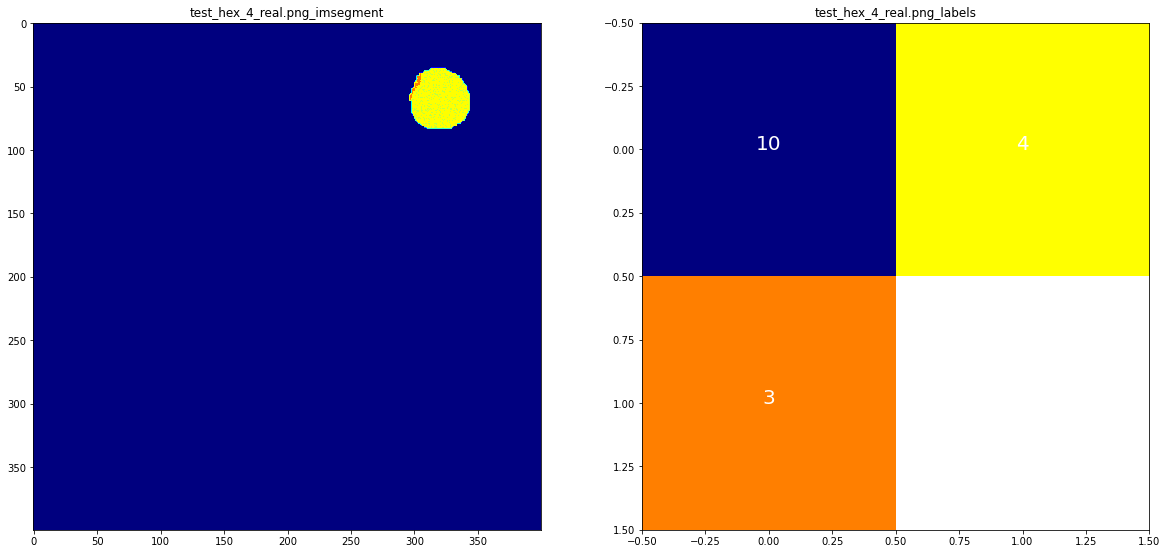

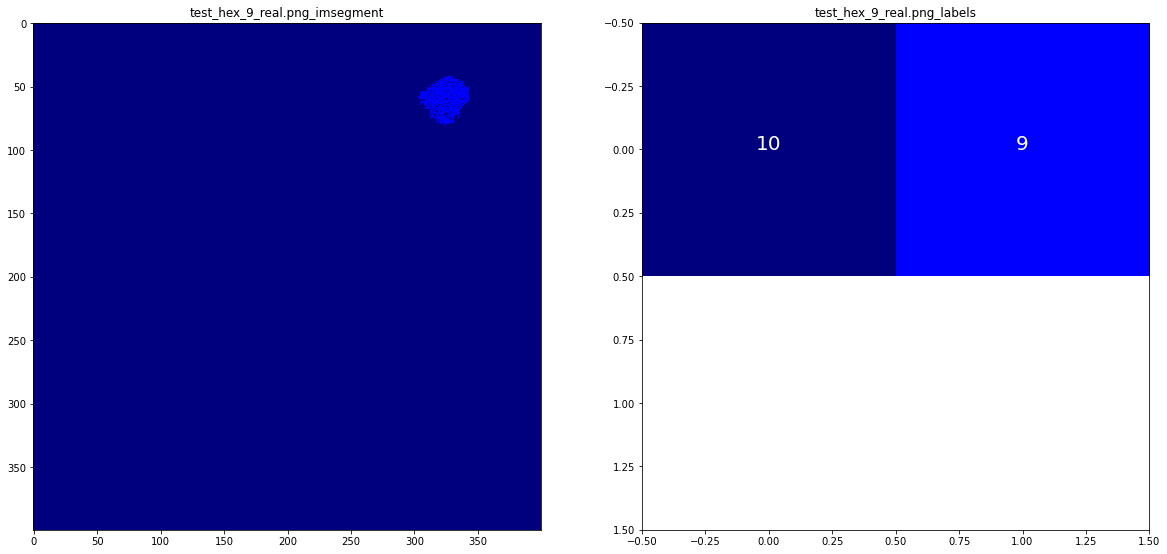

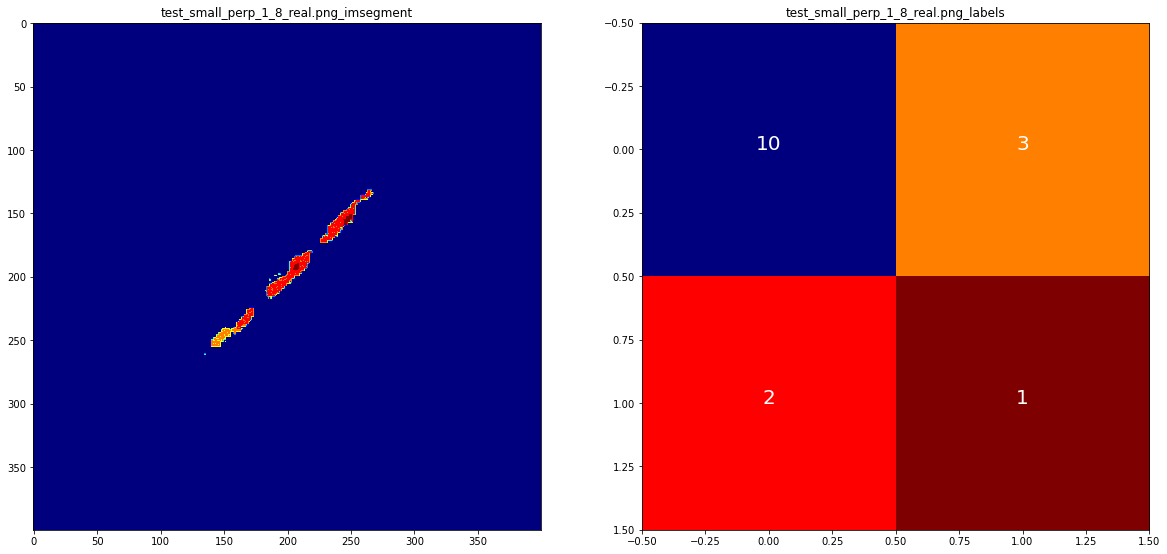

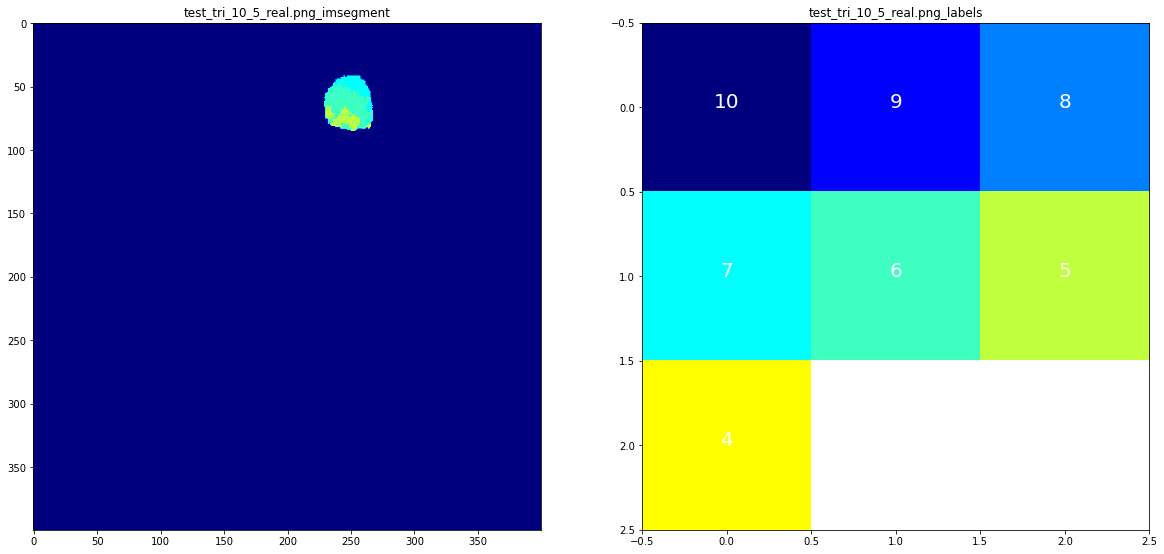

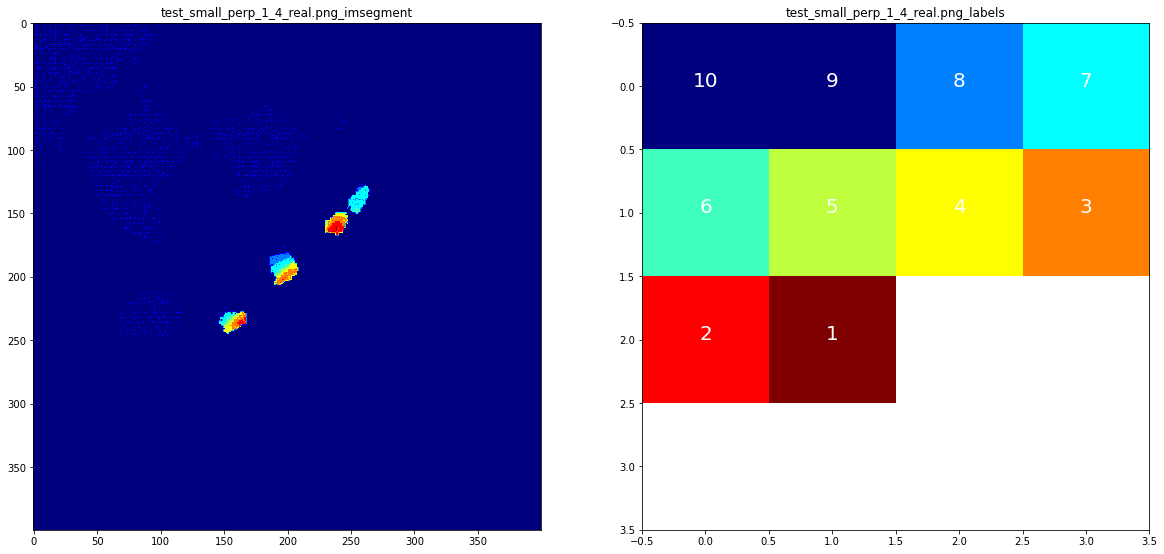

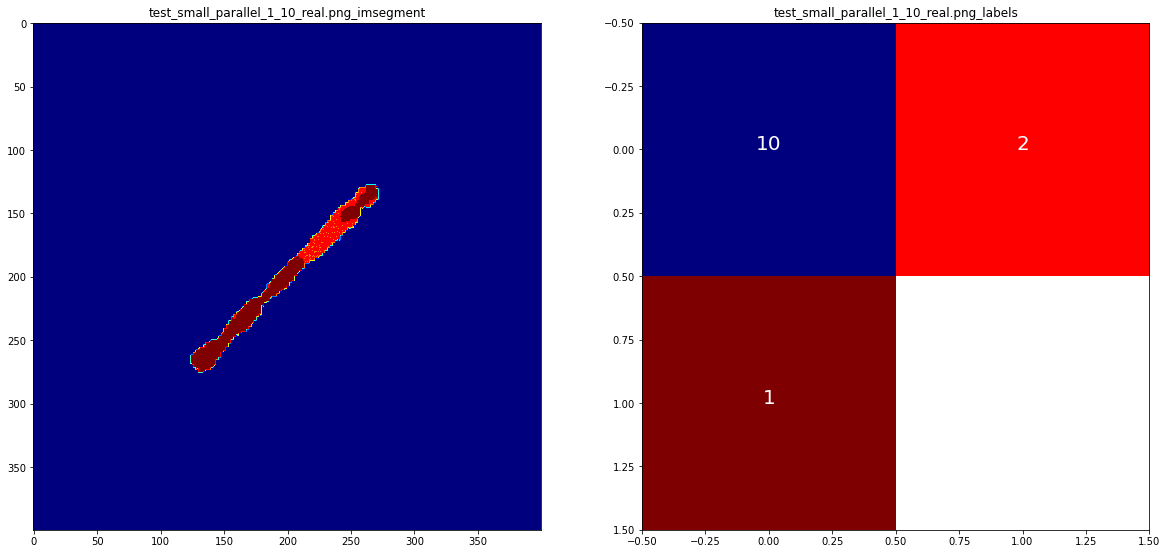

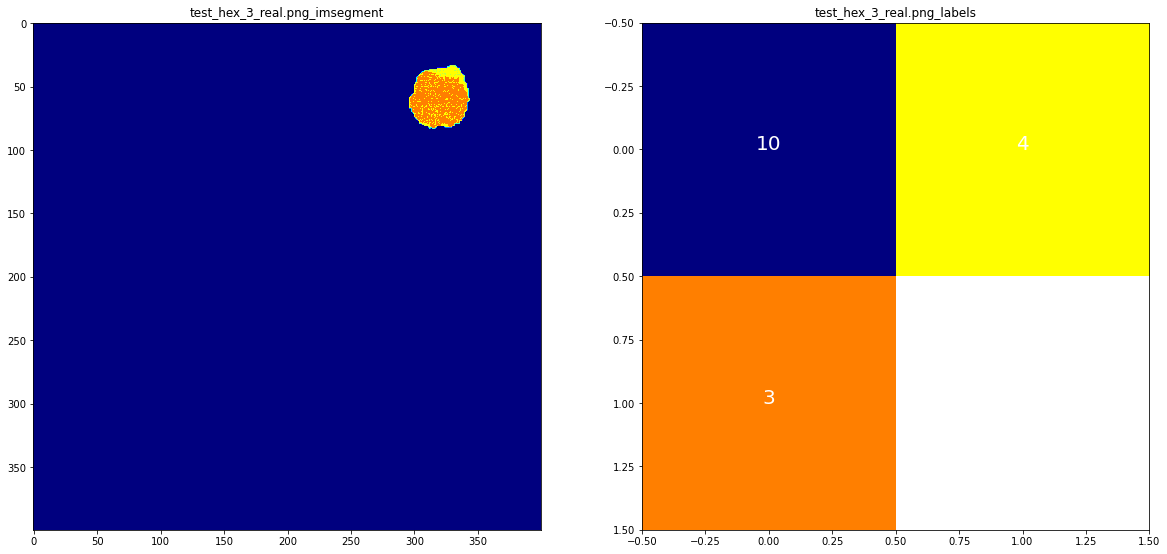

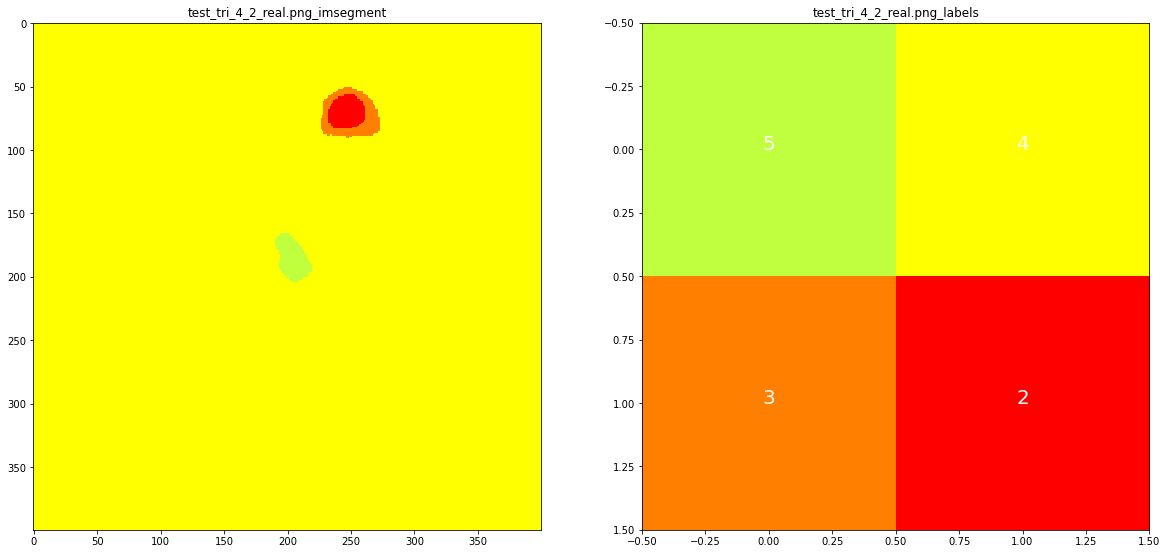

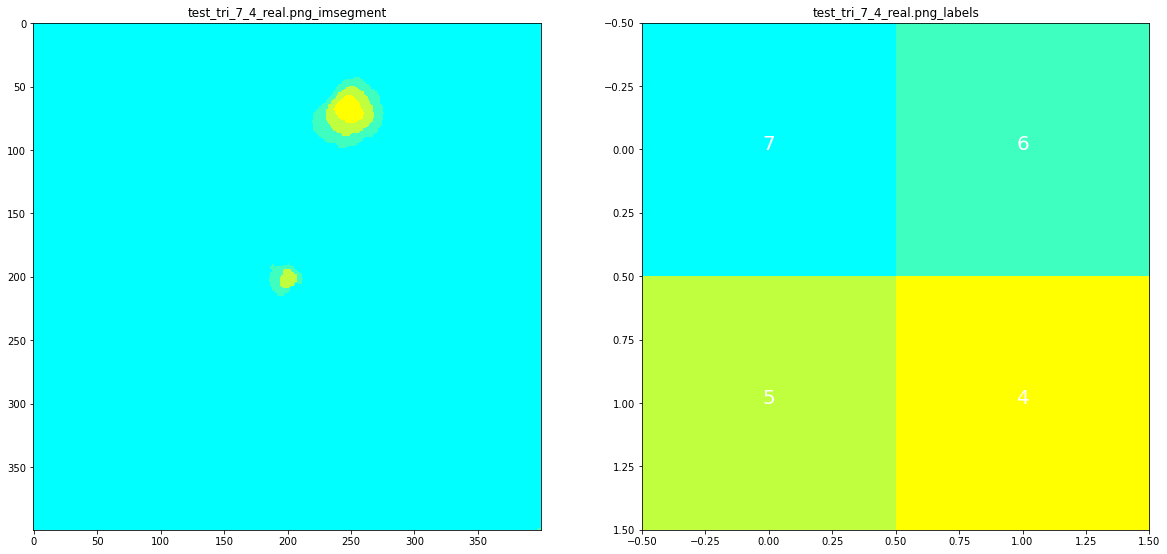

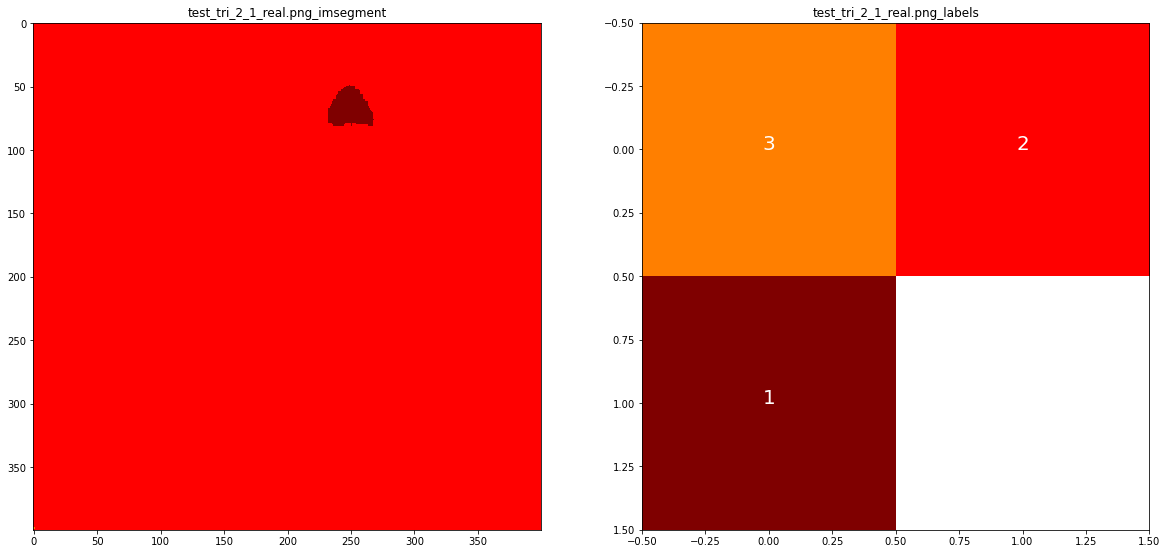

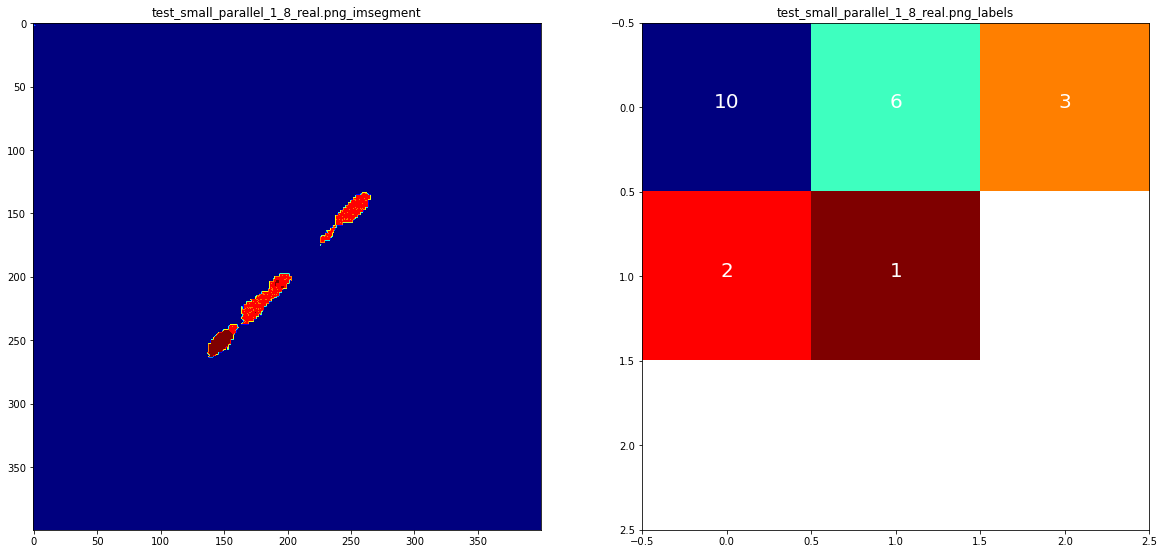

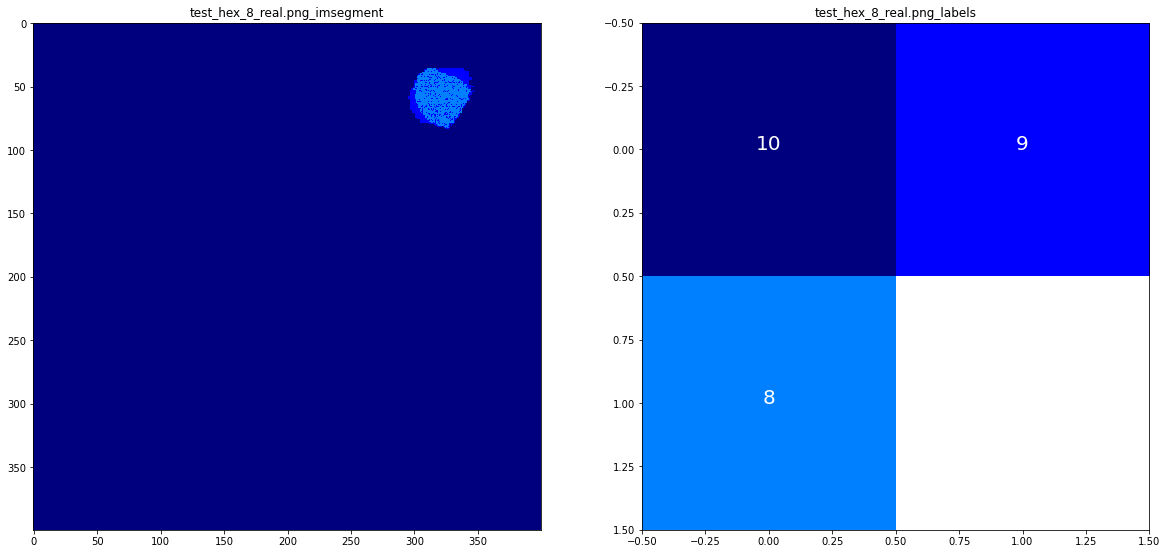

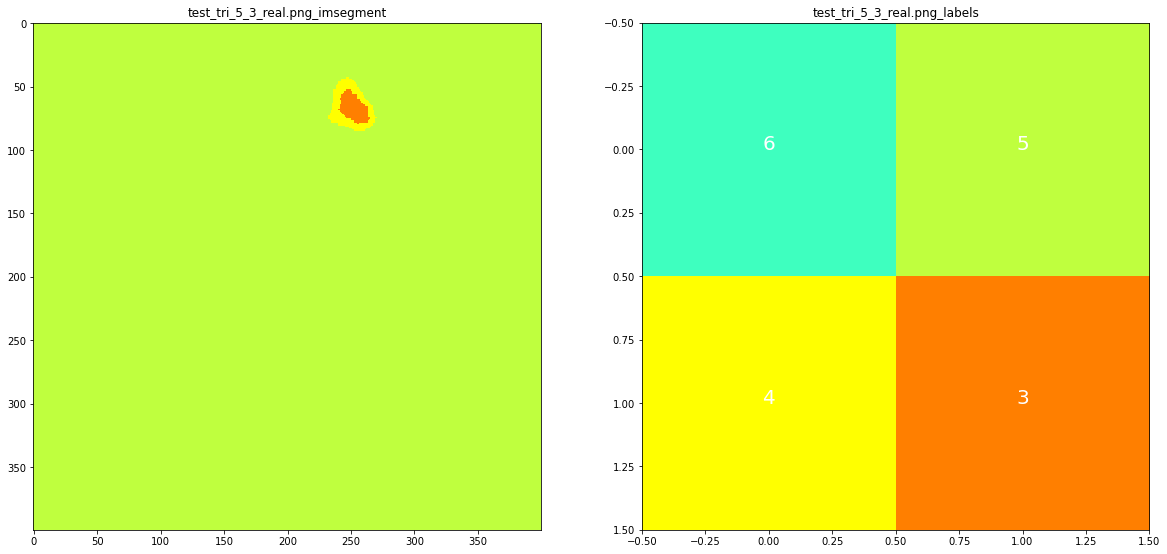

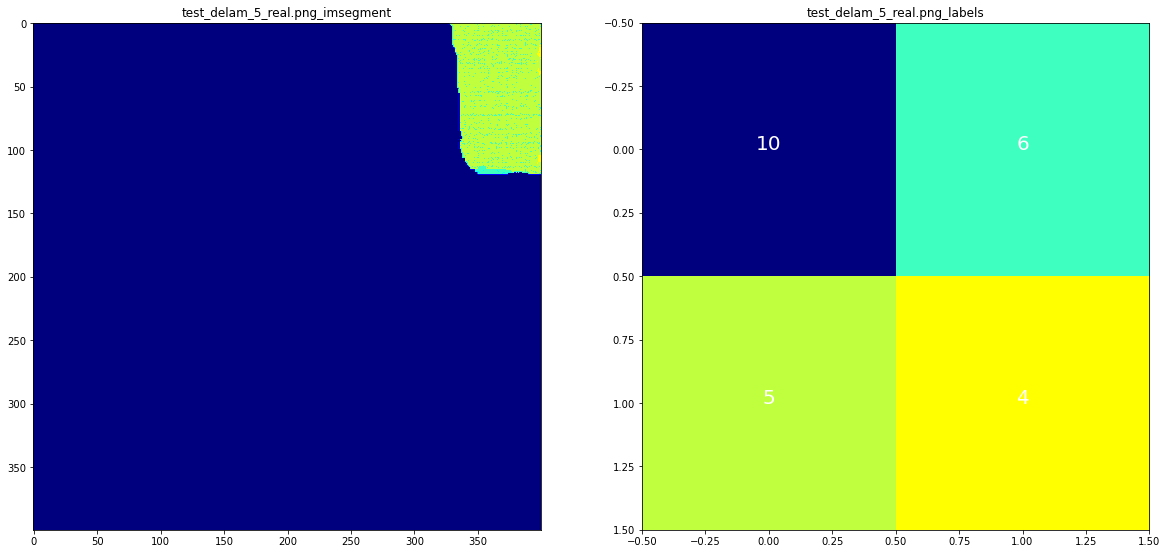

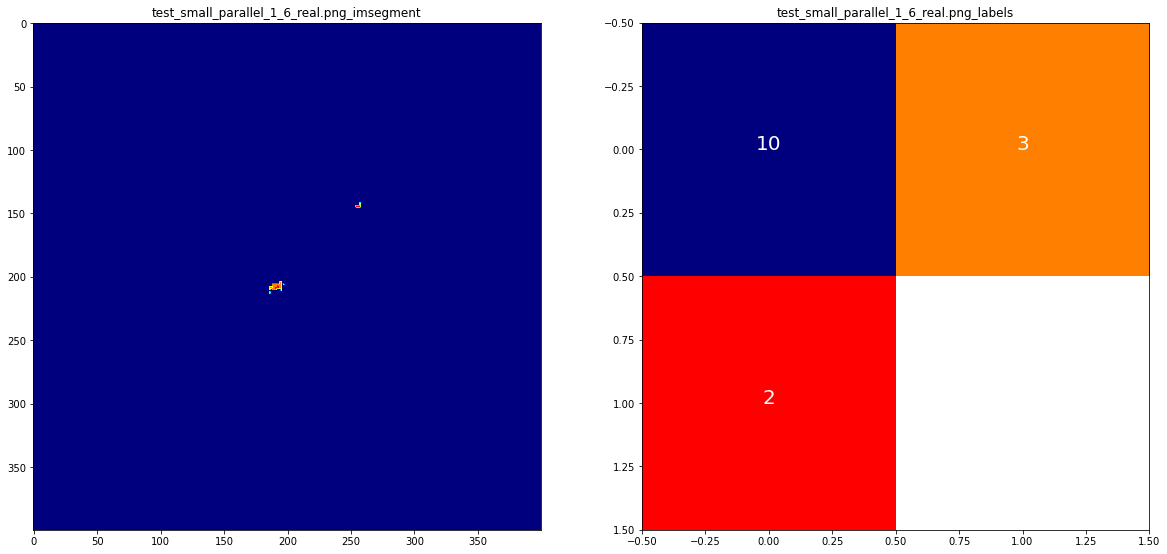

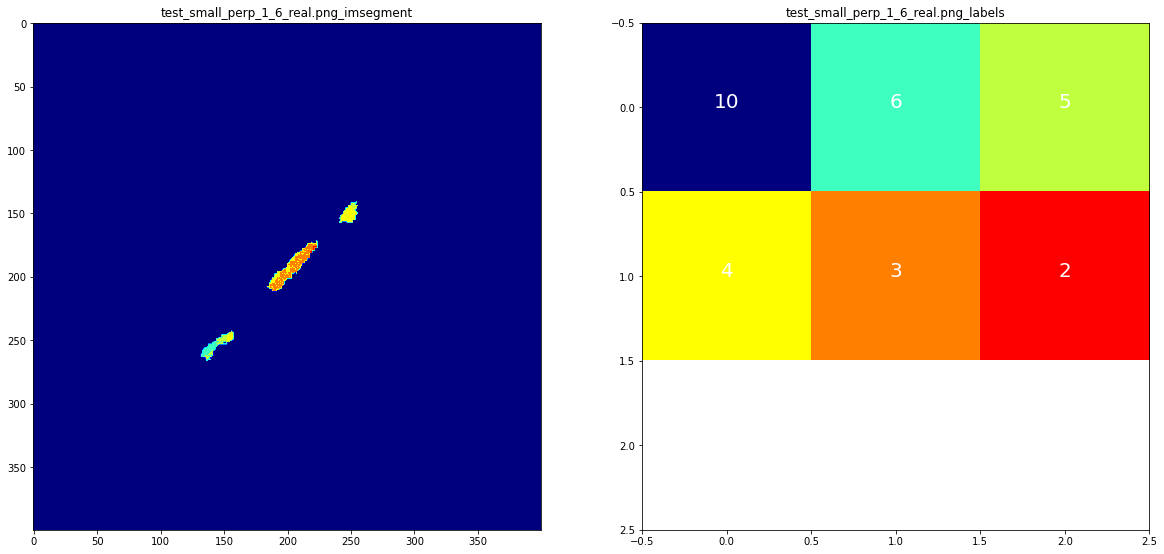

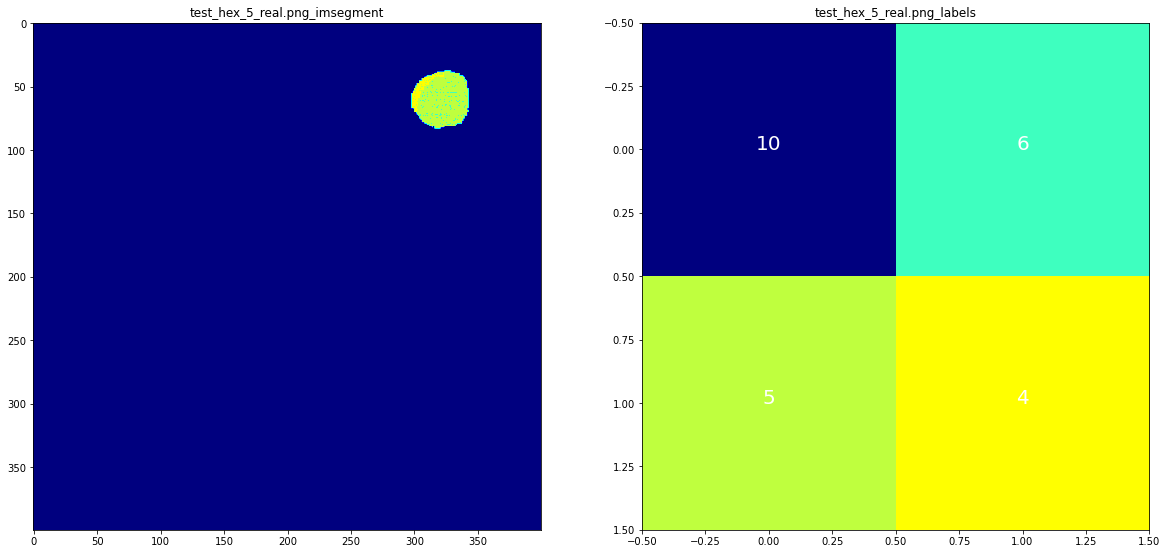

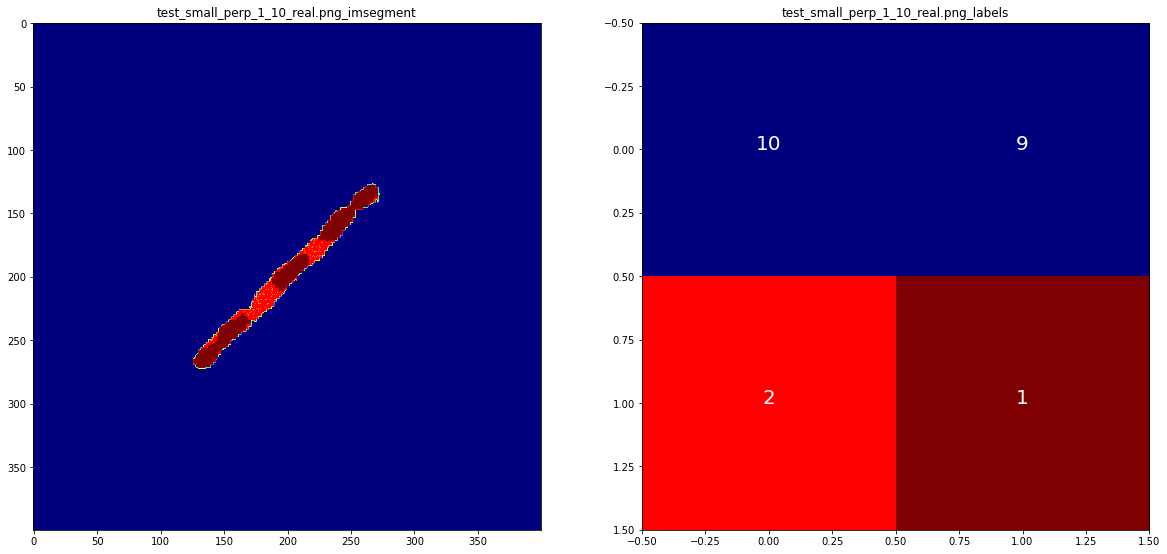

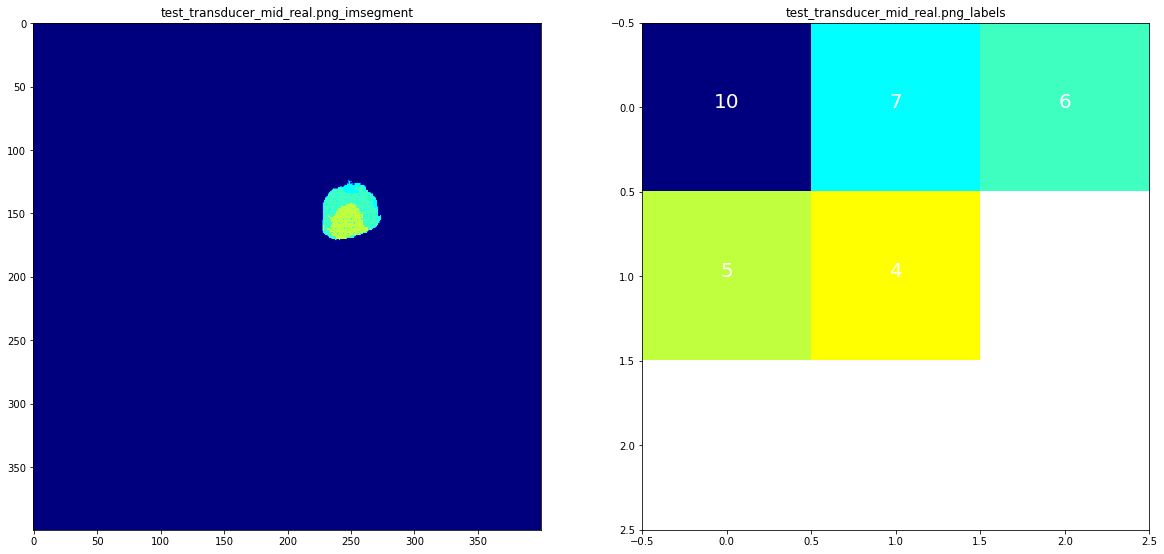

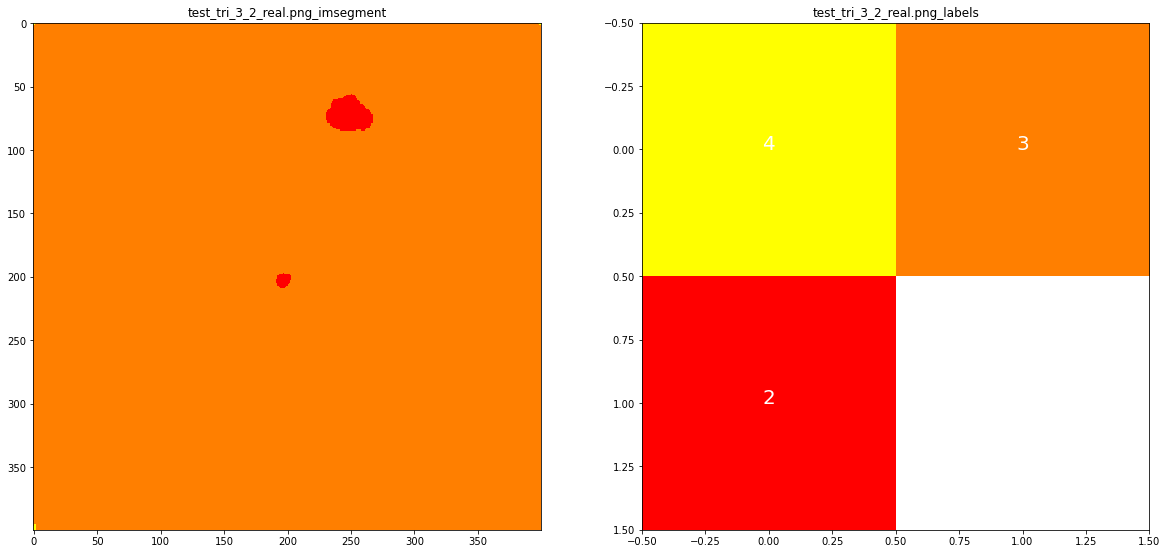

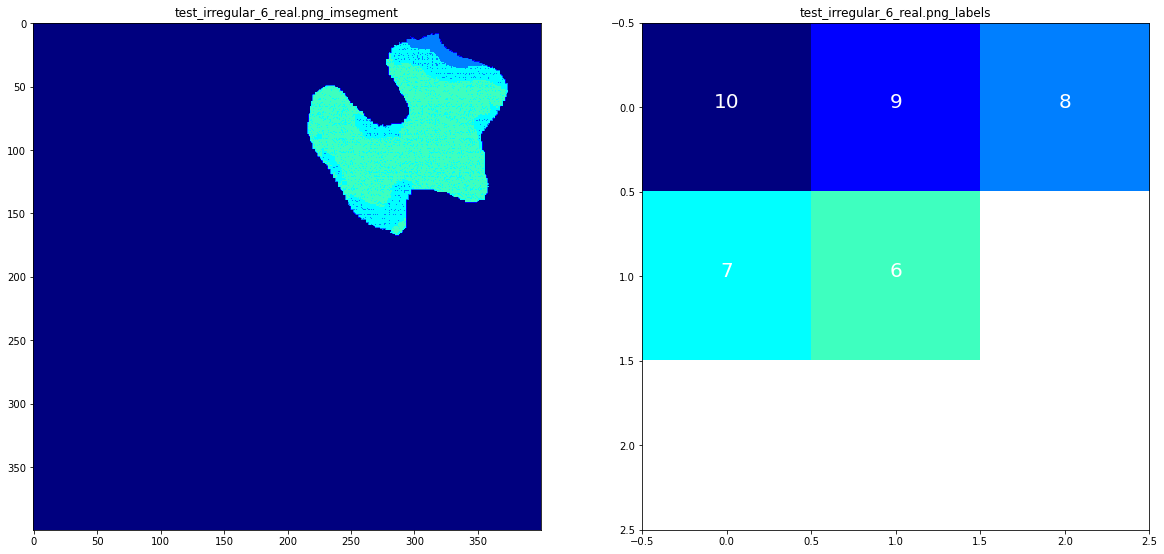

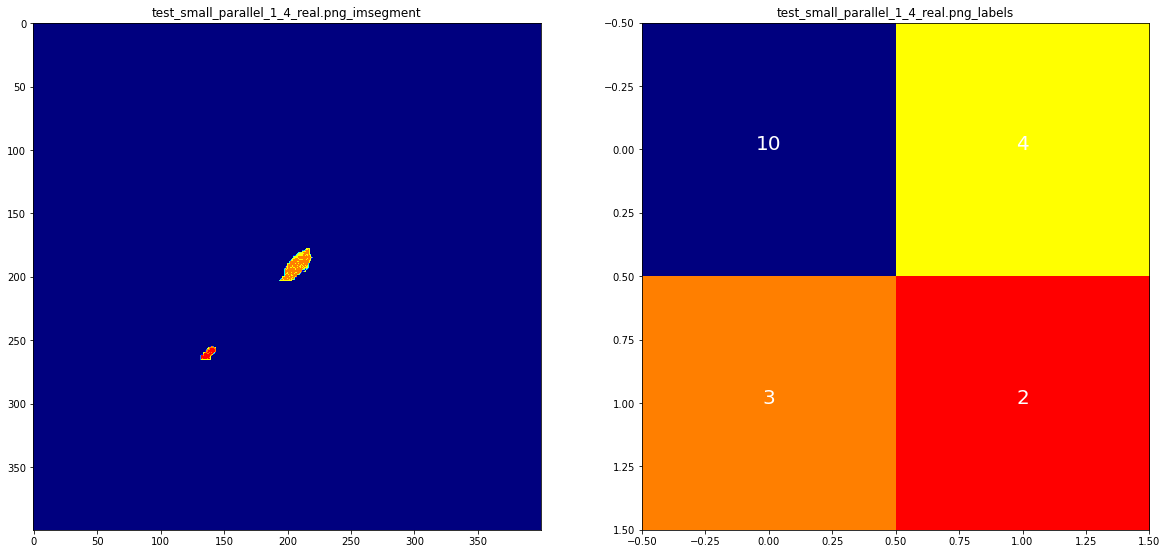

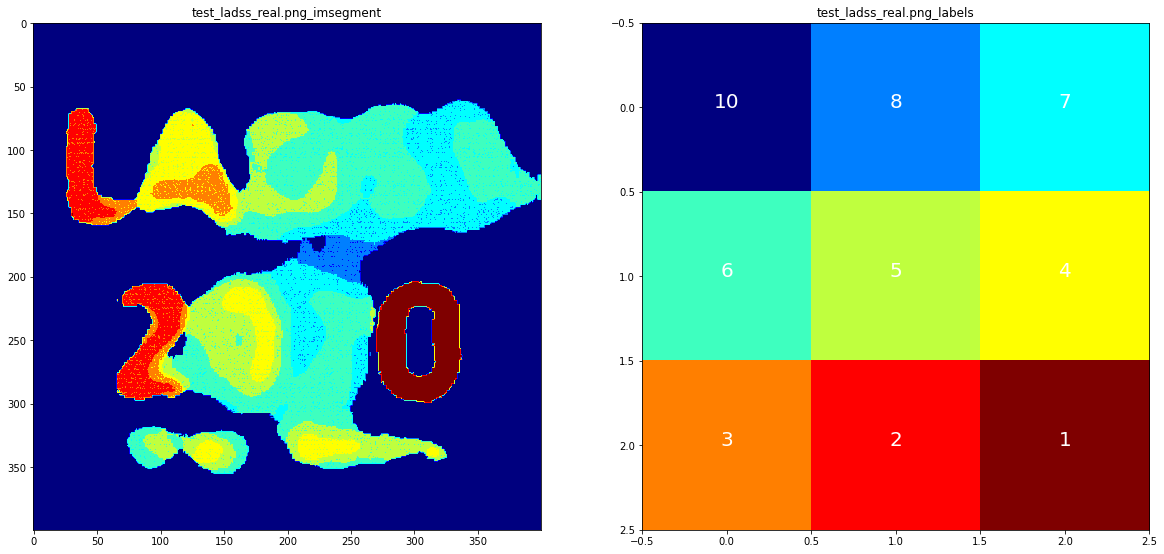

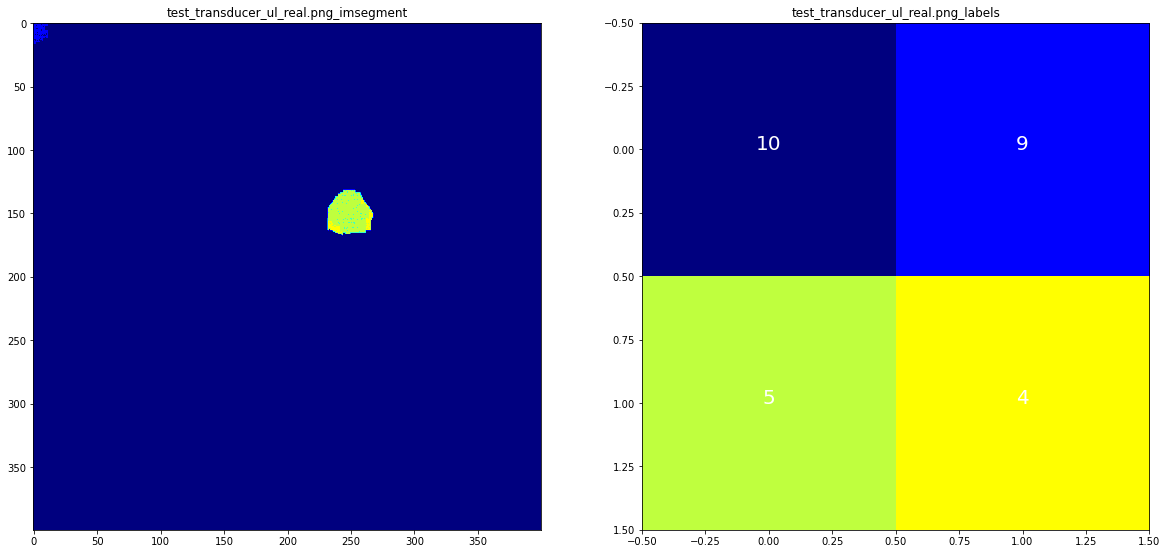

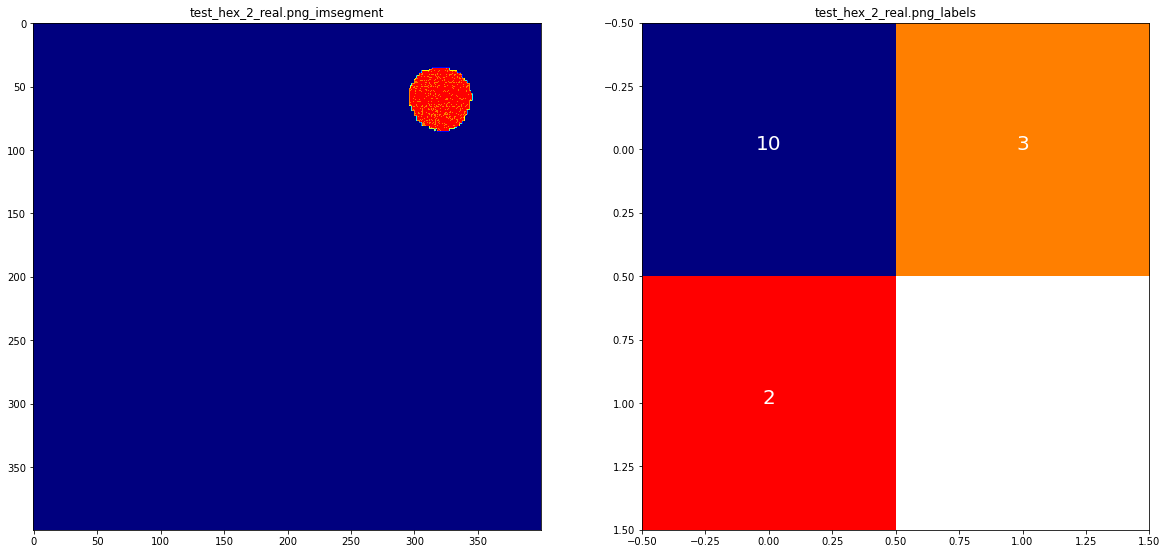

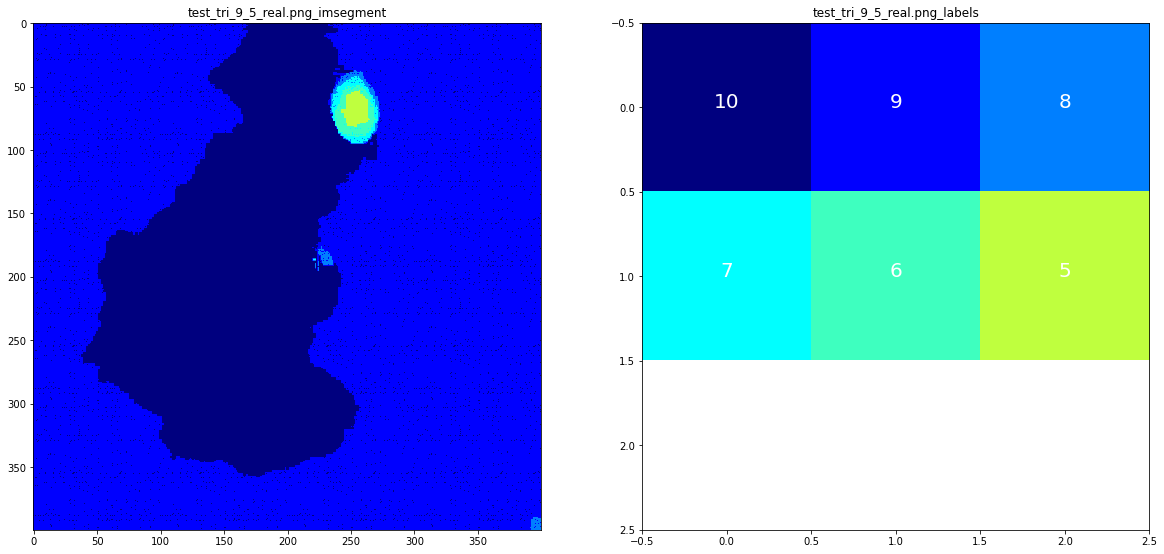

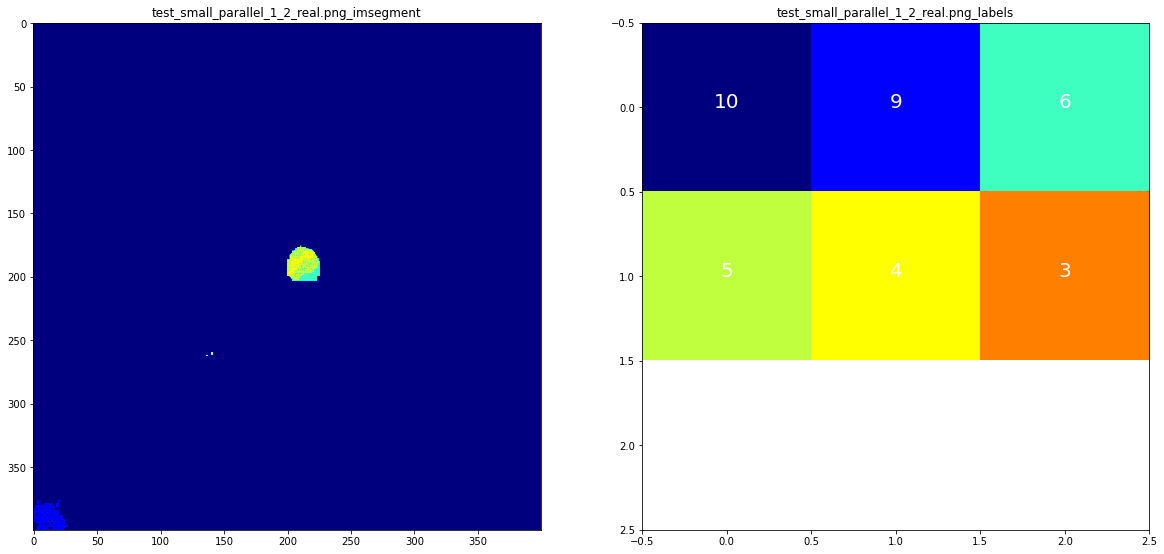

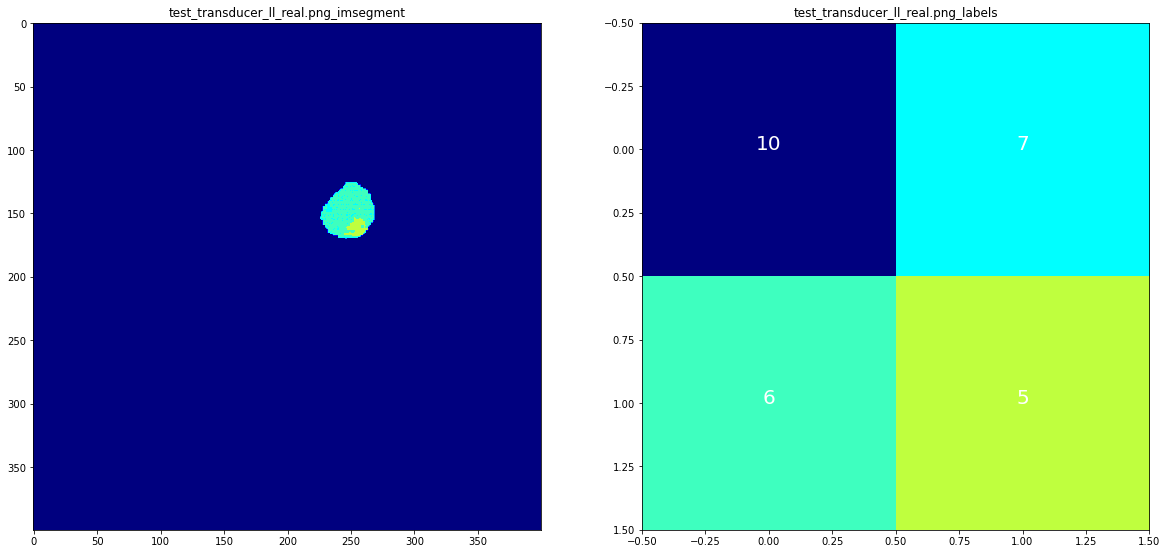

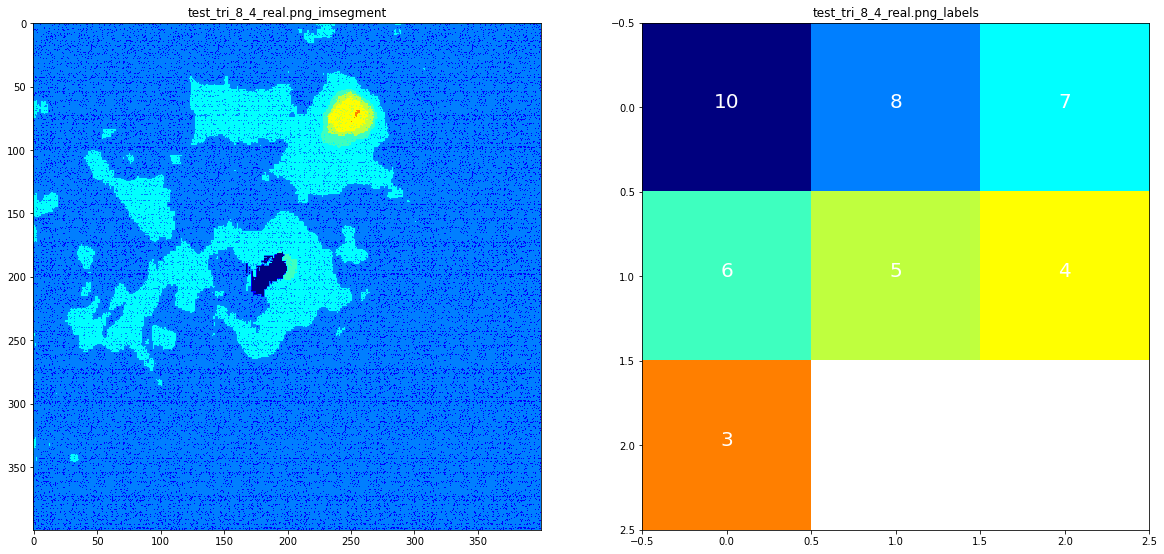

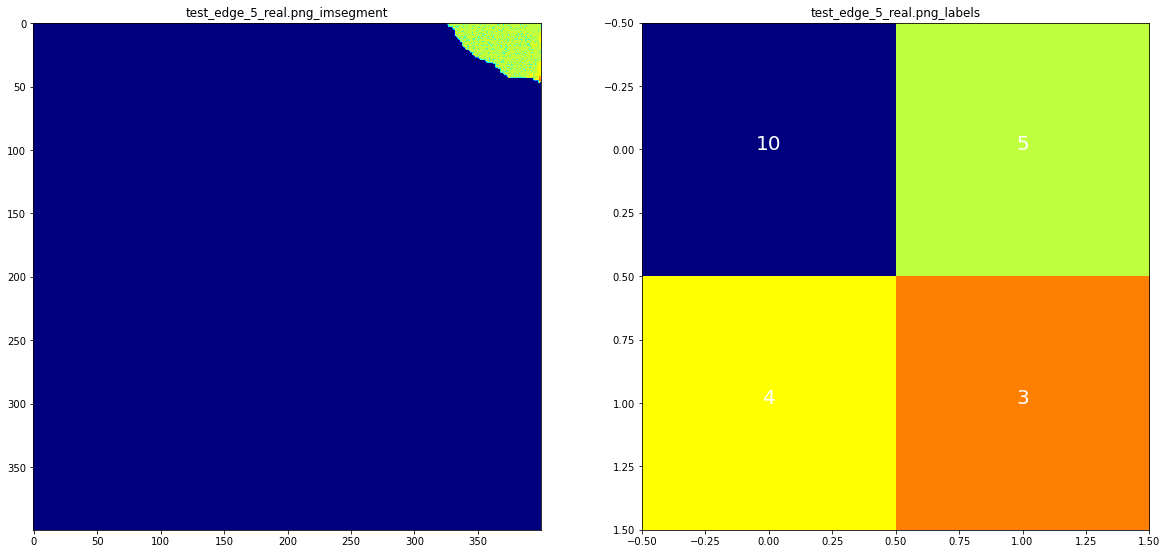

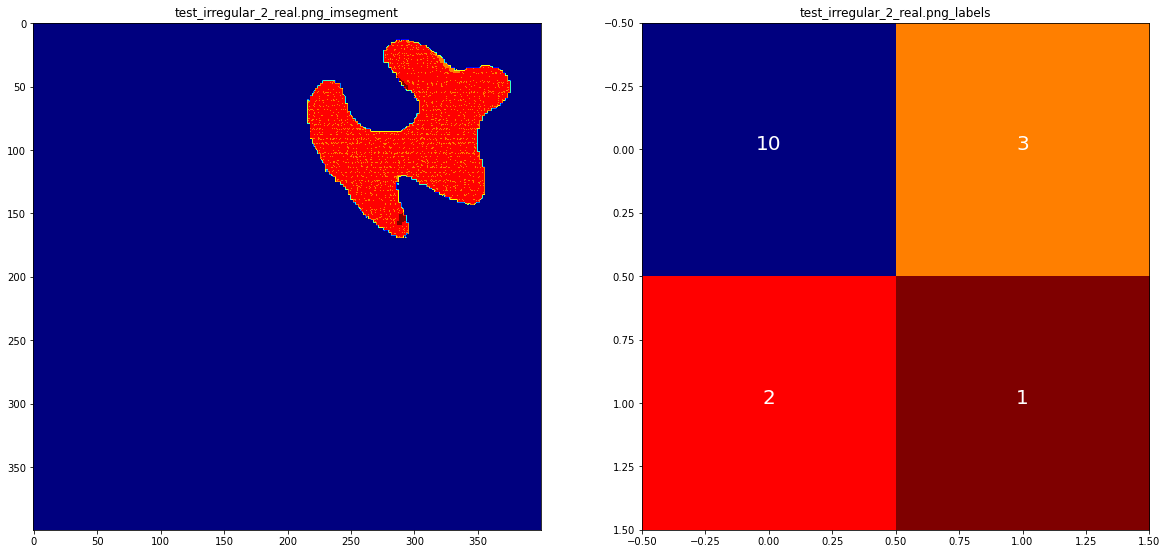

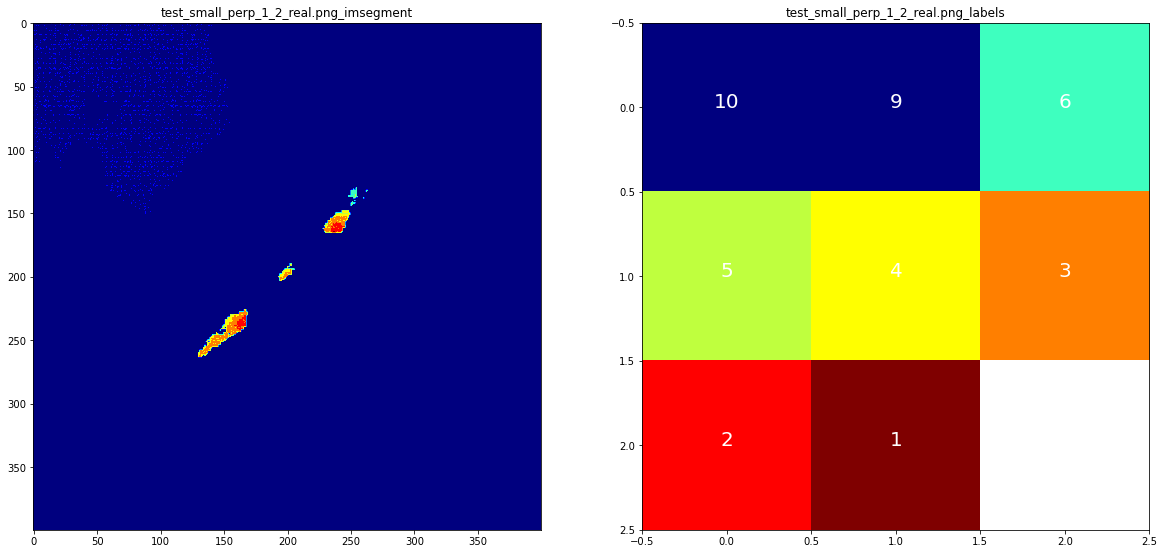

In [19]:
# loop through all test images
for f in files:
    test_img = open_image(f'../test/{f}')
    
    # Show single prediction
    pred = learn.predict(test_img)
    # test_img.show(y=pred[0])
    # pred = tuple(ImageSegment,Tensor[1,720,960],Tensor[32,720,960])
    #      = tuple(mask image, class pixel values, probabilities)
    
    # Save prediction
    
    # Show segmentation interpretation grid with titles
    interp._interp_show(pred[0],classes,title_suffix=f,cmap=cmap,norm=norm)

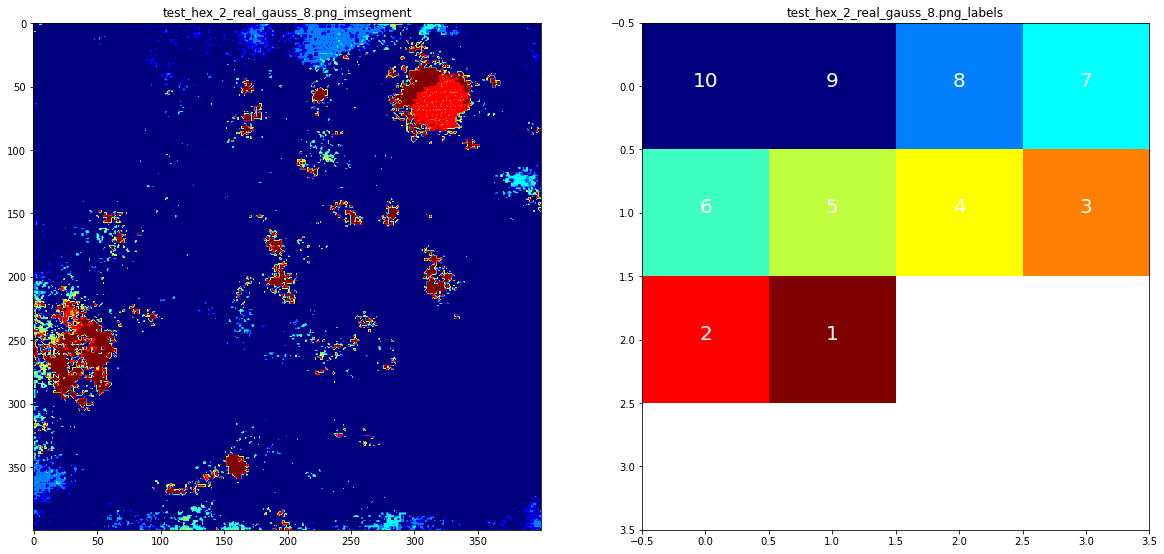

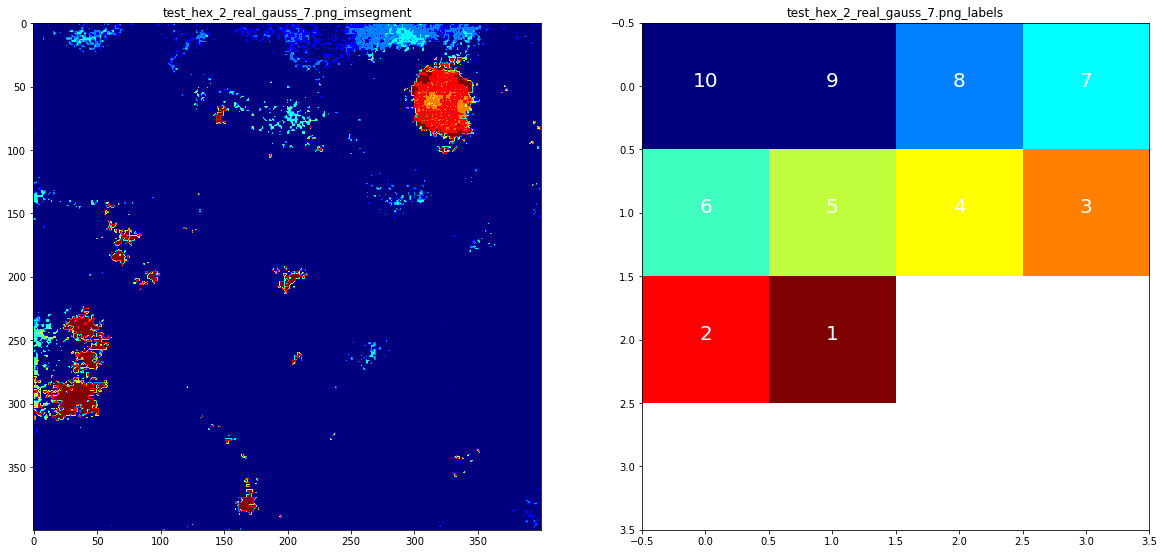

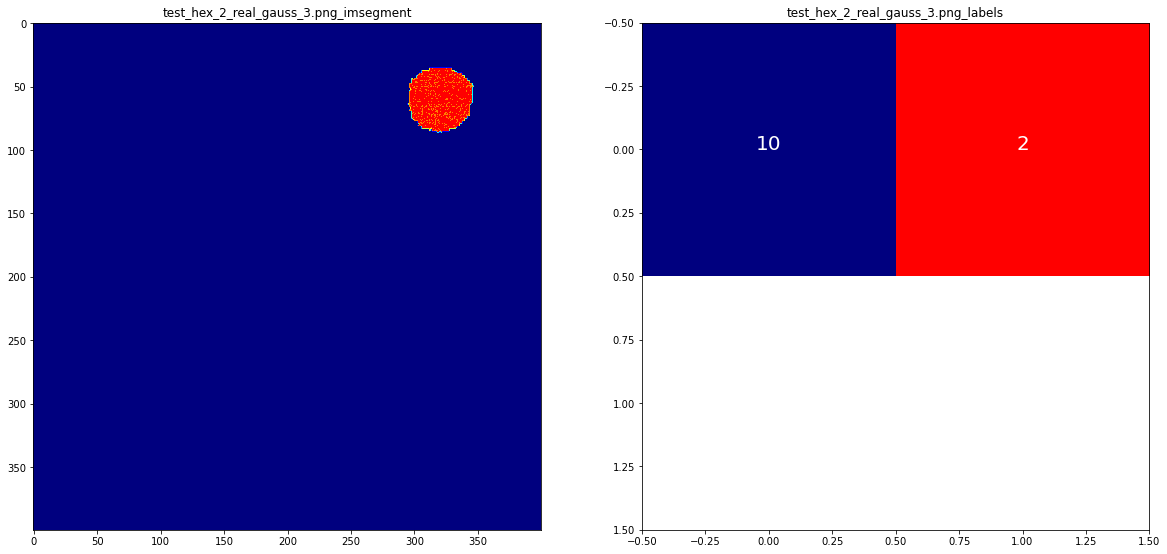

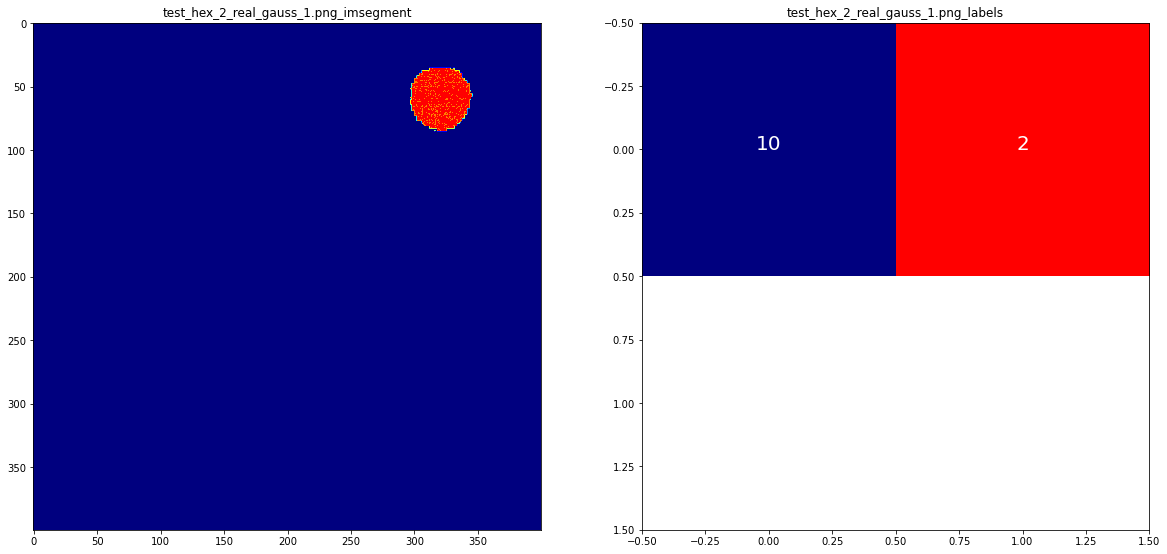

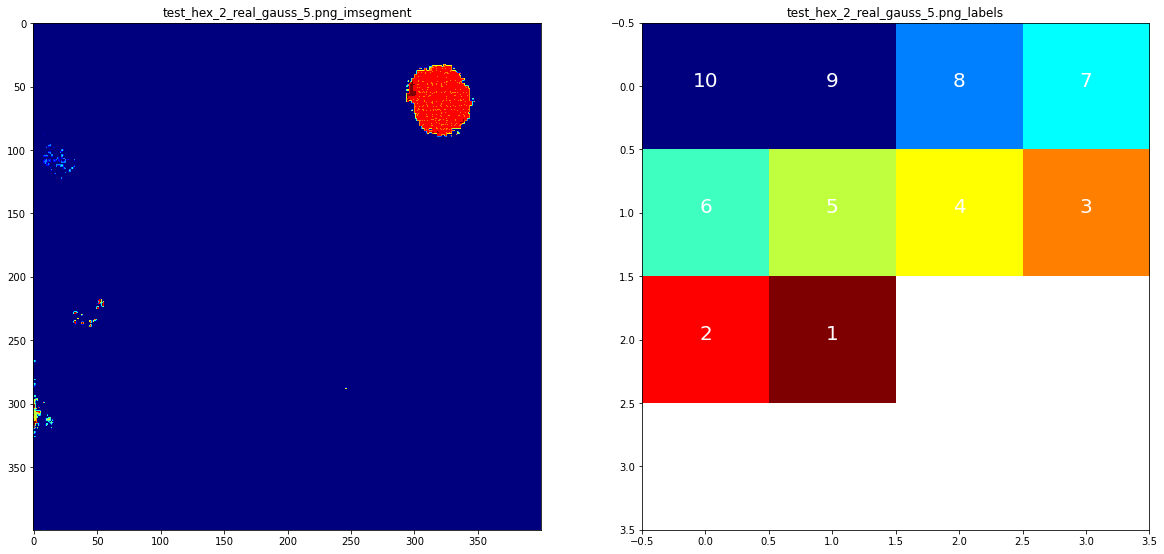

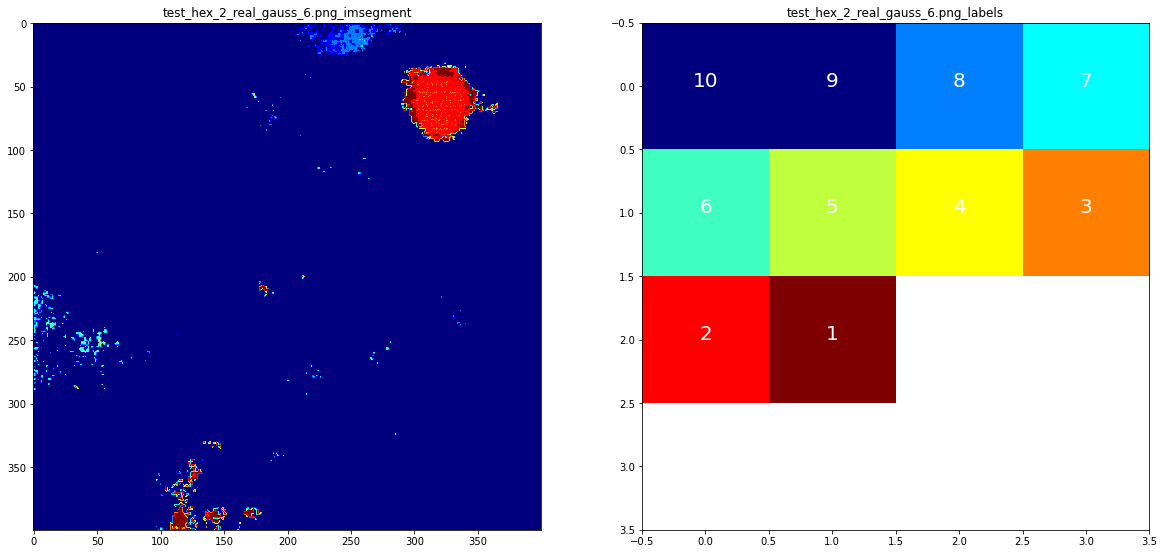

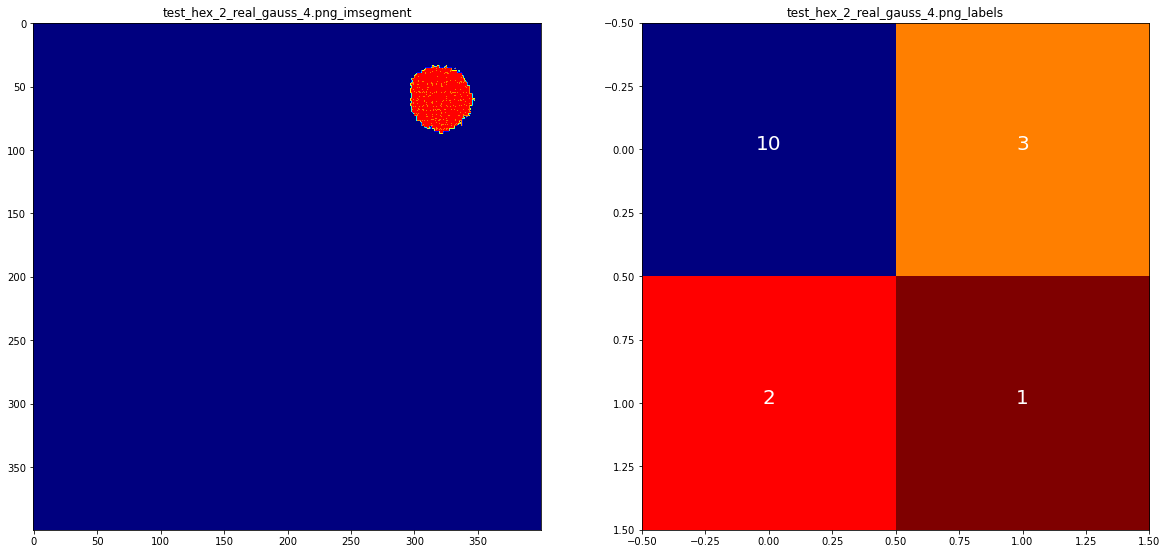

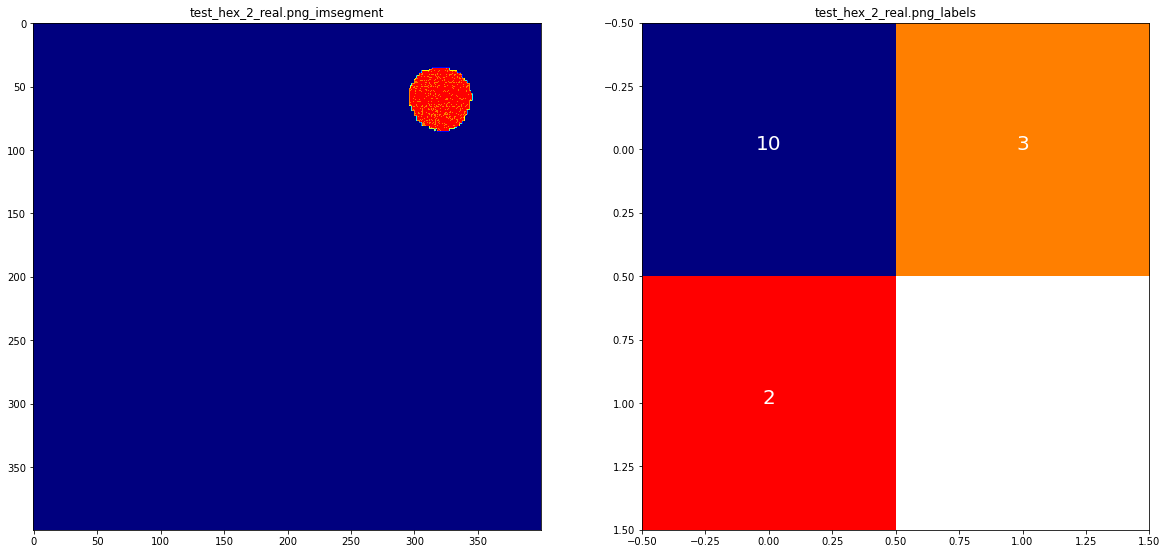

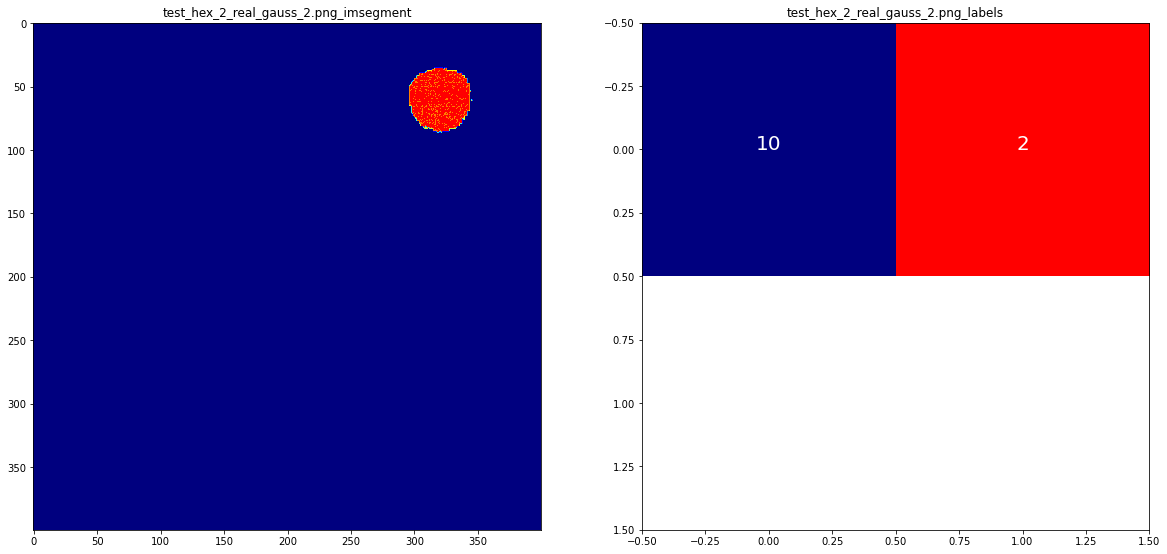

In [39]:
# Test noise
files = [f for f in os.listdir("../noise") if not f.startswith(".")]
for f in files:
    noise_img = open_image(f'../noise/{f}')
    
    # Show single prediction
    pred = learn.predict(noise_img)
    # test_img.show(y=pred[0])
    # pred = tuple(ImageSegment,Tensor[1,720,960],Tensor[32,720,960])
    #      = tuple(mask image, class pixel values, probabilities)
    
    # Save prediction
    
    # Show segmentation interpretation grid with titles
    interp._interp_show(pred[0],classes,title_suffix=f,cmap=cmap,norm=norm)